In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from tqdm import tqdm
from rdkit.Chem import rdFMCS
import os
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
from scipy.stats import kendalltau


def get_tanimoto_similarity(row):
    ligand = row['Docked']
    # Assuming that Template is somehow related to Ligand
    # For example, if templates correspond to ligands directly:
    template = row['Template']
    # Here we would retrieve the similarity based on the Ligand
    # Assuming we want to compare each Ligand with all Ligands and store the score
    # The following just returns the similarity of the Ligand with itself
    try:
        ts = similarity_matrix.loc[ligand, template]
    except:
        ts = None
    return ts
 

def get_mcs_size(row):
    temp = row['Template']
    dock = row['Docked']
    soft_mcs = Chem.MolFromSmarts(rdFMCS.FindMCS([mol_dict[temp],mol_dict[dock]],
                              atomCompare=rdFMCS.AtomCompare.CompareElements,
                              bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                              ringMatchesRingOnly=False,
                              timeout=1).smartsString)
 
    return soft_mcs.GetNumAtoms()

# Load data

In [3]:
astex = pd.read_csv('../data/astex_selected_for_docking.csv')
astex['Template'] = astex.PDB + '_' + astex.Lig

astex = astex[astex.UniProt_ID != 'P04818']

temp_smi_dict = dict(zip(astex.Template, astex.Smiles_String))
mol_dict = {name: Chem.MolFromSmiles(smiles) for name, smiles in temp_smi_dict.items()}
fp_dict = {name: AllChem.GetMorganGenerator(radius=2, fpSize=2048).GetFingerprint(mol) for name, mol in mol_dict.items() if mol is not None}

ligand_names = list(fp_dict.keys())
astex = astex[astex['Template'].isin(ligand_names)]

group_cols = ['UniProt_ID', 'Template', 'Docked']
uniprots = astex.UniProt_ID.unique()

if os.path.exists('../data/similarity_matrix.csv'):
    similarity_matrix = pd.read_csv('similarity_matrix.csv')
    similarity_matrix.index = similarity_matrix.columns
else:
    print('Similarity matrix not found')

[17:16:45] Explicit valence for atom # 7 Cl, 5, is greater than permitted
[17:16:45] Explicit valence for atom # 35 O, 2, is greater than permitted


In [4]:
count_df = astex.groupby('UniProt_ID').size().reset_index(name='count')

for uni in uniprots:
    lig_list = astex[astex.UniProt_ID == uni].Template.to_list()
    sim_df = similarity_matrix.loc[lig_list, lig_list]
    
    count6 = (sim_df.where(np.triu(np.ones(sim_df.shape), k=1) == 1) >= 0.6).sum().sum()
    count7 = (sim_df.where(np.triu(np.ones(sim_df.shape), k=1) == 1) >= 0.7).sum().sum()

    count_df.loc[count_df['UniProt_ID'] == uni, 'TS_6'] = int(count6*2)
    count_df.loc[count_df['UniProt_ID'] == uni, 'TS_7'] = int(count7*2)

tot = (count_df['count'] * (count_df['count'] - 1)).sum()
ts_6_pairs = int(count_df.TS_6.sum())
ts_7_pairs = int(count_df.TS_7.sum())

print(tot)
print(ts_6_pairs)
print(ts_7_pairs)

228284
2986
1326


In [5]:
cross_fd = pd.read_csv('../data/cross_free_docking_results.csv')
cross_td = pd.read_csv('../data/cross_template_docking_results.csv')


In [6]:
cross_fd_worked = len(cross_fd.Docked.unique())
cross_td_worked = len(cross_td.Docked.unique())

print(f'FD ligands with at least one pose:  {round(cross_fd_worked/2007, 2)}')
print(f'TBD ligands with at least one pose: {round(cross_td_worked/2007, 2)}')

cross_fd_docked = len(cross_fd.drop_duplicates(subset=['Template', 'Docked']).dropna(subset=['flexx_rmsd', 'hyde_rmsd']))
cross_td_docked = len(cross_td.drop_duplicates(subset=['Template', 'Docked']).dropna(subset=['flexx_rmsd', 'hyde_rmsd']))

print(f'FD teplate-ligand pair with at least one pose:  {round(cross_fd_docked/tot, 2)}')
print(f'TBD teplate-ligand pair with at least one pose: {round(cross_td_docked/tot, 2)}')

FD ligands with at least one pose:  0.99
TBD ligands with at least one pose: 0.98
FD teplate-ligand pair with at least one pose:  0.82
TBD teplate-ligand pair with at least one pose: 0.68


Add TS values to the docking results dataframes

In [7]:
cross_fd['Tanimoto_Similarity'] = cross_fd.apply(get_tanimoto_similarity, axis=1)
cross_td['Tanimoto_Similarity'] = cross_td.apply(get_tanimoto_similarity, axis=1)


# Top1 and top10 FlexX and HYDE score

In [8]:
print(f'Cross free docking: {cross_fd_docked}')
print(f'Cross template-ligand docking: {cross_td_docked}')

Cross free docking: 188195
Cross template-ligand docking: 155712


In [9]:
fd_flexx_score = cross_fd.dropna(subset='flexx_rmsd').reset_index(drop=True)
fd_hyde_score = cross_fd.dropna(subset='hyde_rmsd').reset_index(drop=True)

fd_flexx_score_top1 = fd_flexx_score.loc[fd_flexx_score.groupby(group_cols)['flexx_score'].idxmin()]
fd_flexx_rmsd_top1 = fd_flexx_score.loc[fd_flexx_score.groupby(group_cols)['flexx_rmsd'].idxmin()]

fd_flexx_score_sr = round(len(fd_flexx_score_top1[fd_flexx_score_top1.flexx_rmsd <= 2])/len(fd_flexx_score_top1), 2)
fd_flexx_rmsd_sr = round(len(fd_flexx_rmsd_top1[fd_flexx_rmsd_top1.flexx_rmsd <= 2])/len(fd_flexx_rmsd_top1), 2)

fd_hyde_score_top1 = fd_hyde_score.loc[fd_hyde_score.groupby(group_cols)['hyde_score'].idxmin()]
fd_hyde_rmsd_top1 = fd_hyde_score.loc[fd_hyde_score.groupby(group_cols)['hyde_rmsd'].idxmin()]

fd_hyde_score_sr = round(len(fd_hyde_score_top1[fd_hyde_score_top1.hyde_rmsd <= 2])/len(fd_hyde_score_top1), 2)
fd_hyde_rmsd_sr = round(len(fd_hyde_rmsd_top1[fd_hyde_rmsd_top1.hyde_rmsd <= 2])/len(fd_hyde_rmsd_top1), 2)

In [10]:
td_flexx_score = cross_td.dropna(subset='flexx_rmsd').reset_index(drop=True)
td_hyde_score = cross_td.dropna(subset='hyde_rmsd').reset_index(drop=True)

td_flexx_score_top1 = td_flexx_score.loc[td_flexx_score.groupby(group_cols)['flexx_score'].idxmin()]
td_flexx_rmsd_top1 = td_flexx_score.loc[td_flexx_score.groupby(group_cols)['flexx_rmsd'].idxmin()]

td_flexx_score_sr = round(len(td_flexx_score_top1[td_flexx_score_top1.flexx_rmsd <= 2])/len(td_flexx_score_top1), 2)
td_flexx_rmsd_sr = round(len(td_flexx_rmsd_top1[td_flexx_rmsd_top1.flexx_rmsd <= 2])/len(td_flexx_rmsd_top1), 2)

td_hyde_score_top1 = td_hyde_score.loc[td_hyde_score.groupby(group_cols)['hyde_score'].idxmin()]
td_hyde_rmsd_top1 = td_hyde_score.loc[td_hyde_score.groupby(group_cols)['hyde_rmsd'].idxmin()]

td_hyde_score_sr = round(len(td_hyde_score_top1[td_hyde_score_top1.hyde_rmsd <= 2])/len(td_hyde_score_top1), 2)
td_hyde_rmsd_sr = round(len(td_hyde_rmsd_top1[td_hyde_rmsd_top1.hyde_rmsd <= 2])/len(td_hyde_rmsd_top1), 2)


In [11]:
cross_docking_success_rate = pd.DataFrame(
     {
      'Total poses': [cross_fd_docked, cross_td_docked],
      '% of enriched Astex': [round(cross_fd_docked/228284, 2)*100, 
                              round(cross_td_docked/228284, 2)*100],
      'Poses flexx best': [len(fd_flexx_score_top1[fd_flexx_score_top1.flexx_rmsd < 2]),
                           len(td_flexx_score_top1[td_flexx_score_top1.flexx_rmsd < 2])],
      'Flexx best (%)':[fd_flexx_score_sr*100, td_flexx_score_sr*100],
      'Poses flexx top10': [len(fd_flexx_rmsd_top1[fd_flexx_rmsd_top1.flexx_rmsd < 2]),
                            len(td_flexx_rmsd_top1[td_flexx_rmsd_top1.flexx_rmsd < 2])],
      'Flexx top 10 (%)': [fd_flexx_rmsd_sr*100, td_flexx_rmsd_sr*100],
      'Poses HYDE best': [len(fd_hyde_score_top1[fd_hyde_score_top1.hyde_rmsd < 2]),
                          len(td_hyde_score_top1[td_hyde_score_top1.hyde_rmsd < 2])],
      'HYDE best (%)': [fd_hyde_score_sr*100, td_hyde_score_sr*100],
      'Poses HYDE top10': [len(fd_hyde_rmsd_top1[fd_hyde_rmsd_top1.hyde_rmsd < 2]),
                           len(td_hyde_rmsd_top1[td_hyde_rmsd_top1.hyde_rmsd < 2])],
      'HYDE top10 (%)': [fd_hyde_rmsd_sr*100, td_hyde_rmsd_sr*100]
     }, index=['Free docking', 'Template based docking']
     )
cross_docking_success_rate = cross_docking_success_rate.T
cross_docking_success_rate = cross_docking_success_rate[['Free docking', 'Template based docking']].astype(int)

In [12]:
cross_docking_success_rate

,Free docking,Template based docking
Total poses,188195,155712
% of enriched Astex,82,68
Poses flexx best,38963,23515
Flexx best (%),21,15
Poses flexx top10,73842,34361
Flexx top 10 (%),39,22
Poses HYDE best,48991,26330
HYDE best (%),26,17
Poses HYDE top10,77242,36734
HYDE top10 (%),41,24


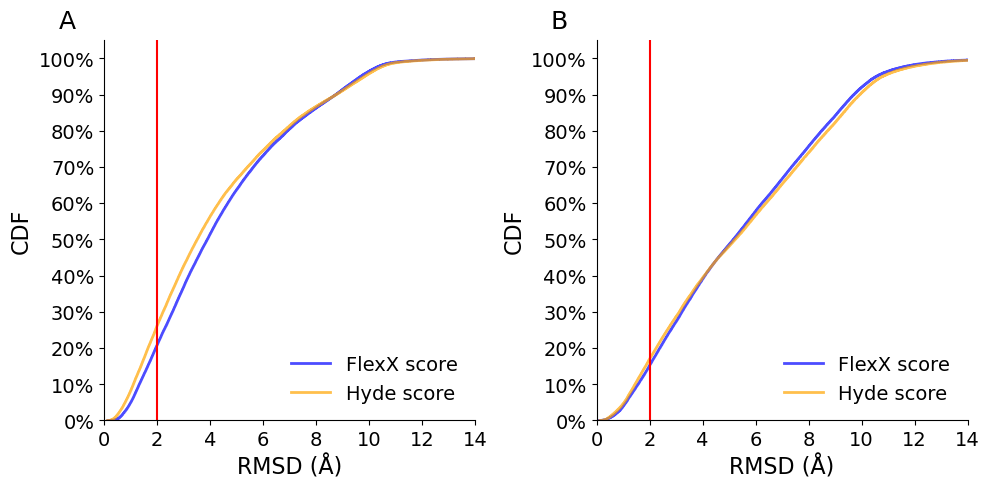

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

bins = np.arange(0, 15, 1)

# --- Plot A ---
ax = axes[0]
ax.ecdf(fd_flexx_score_top1.flexx_rmsd, alpha=0.7, label='FlexX score', linewidth=2, linestyle='-', color='blue')
ax.ecdf(fd_hyde_score_top1.hyde_rmsd, alpha=0.7, label='Hyde score',  linewidth=2, linestyle='-', color='orange')

ax.set_xlabel('RMSD (Å)', fontsize=16)
ax.set_ylabel('CDF', fontsize=16)
ax.legend(fontsize=14, frameon=False)

ax.set_xticks(np.arange(0, 15, 2))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticklabels([f"{int(ytick * 100)}%" for ytick in np.linspace(0, 1, 11)], fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlim(0, 14)
ax.set_ylim(0, 1.05)
ax.axvline(x=2, color='red', linestyle='-')
ax.text(-0.1, 1.05, 'A', fontsize=18, ha='center', va='center', transform=ax.transAxes)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# --- Plot B ---
ax = axes[1]
ax.ecdf(td_flexx_score_top1.flexx_rmsd, alpha=0.7, label='FlexX score', linewidth=2, linestyle='-', color='blue')
ax.ecdf(td_hyde_score_top1.hyde_rmsd, alpha=0.7, label='Hyde score',  linewidth=2, linestyle='-', color='orange')

ax.set_xlabel('RMSD (Å)', fontsize=16)
ax.set_ylabel('CDF', fontsize=16)  # Optional, if you want Y label on both
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticklabels([f"{int(ytick * 100)}%" for ytick in np.linspace(0, 1, 11)], fontsize=14)

ax.legend(fontsize=14, frameon=False)
ax.set_xticks(np.arange(0, 15, 2))
ax.set_xlim(0, 14)
ax.set_ylim(0, 1.05)
ax.axvline(x=2, color='red', linestyle='-')
ax.text(-0.1, 1.05, 'B', fontsize=18, ha='center', va='center', transform=ax.transAxes)
ax.tick_params(axis='x', labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')


# --- Save combined plot ---
plt.tight_layout()
# plt.show()
plt.savefig('../images/cross_docking_ds_hs.png', dpi=300, bbox_inches='tight', transparent=True)


# Evaluate MCS RMSD and TS

In [13]:
mcs_fd = cross_fd.dropna(subset='mcs_rmsd').reset_index(drop=True)
mcs_td = cross_td.dropna(subset='mcs_rmsd').reset_index(drop=True)

mcs_fd = mcs_fd.drop(columns=['flexx_score', 'flexx_rmsd'])
mcs_td = mcs_td.drop(columns=['flexx_score', 'flexx_rmsd'])

mcs_fd = mcs_fd.dropna(subset='hyde_rmsd').reset_index(drop=True)
mcs_td = mcs_td.dropna(subset='hyde_rmsd').reset_index(drop=True)

# mcs_fd.info(show_counts=True)
# mcs_td.info(show_counts=True)

In [14]:
fd_mcs_10 = mcs_fd[mcs_fd.mcs_rmsd <= 1.0].reset_index(drop=True)
fd_mcs_15 = mcs_fd[mcs_fd.mcs_rmsd <= 1.5].reset_index(drop=True)
fd_mcs_20 = mcs_fd[mcs_fd.mcs_rmsd <= 2.0].reset_index(drop=True)

td_mcs_10 = mcs_td[mcs_td.mcs_rmsd <= 1.0].reset_index(drop=True)
td_mcs_15 = mcs_td[mcs_td.mcs_rmsd <= 1.5].reset_index(drop=True)
td_mcs_20 = mcs_td[mcs_td.mcs_rmsd <= 2.0].reset_index(drop=True)


In [15]:
fd_mcs_10_6 = fd_mcs_10[fd_mcs_10.Tanimoto_Similarity >= 0.6].reset_index(drop=True)
fd_mcs_10_7 = fd_mcs_10[fd_mcs_10.Tanimoto_Similarity >= 0.7].reset_index(drop=True)

fd_mcs_15_6 = fd_mcs_15[fd_mcs_15.Tanimoto_Similarity >= 0.6].reset_index(drop=True)
fd_mcs_15_7 = fd_mcs_15[fd_mcs_15.Tanimoto_Similarity >= 0.7].reset_index(drop=True)

fd_mcs_20_6 = fd_mcs_20[fd_mcs_20.Tanimoto_Similarity >= 0.6].reset_index(drop=True)
fd_mcs_20_7 = fd_mcs_20[fd_mcs_20.Tanimoto_Similarity >= 0.7].reset_index(drop=True)


td_mcs_10_6 = td_mcs_10[td_mcs_10.Tanimoto_Similarity >= 0.6].reset_index(drop=True)
td_mcs_10_7 = td_mcs_10[td_mcs_10.Tanimoto_Similarity >= 0.7].reset_index(drop=True)

td_mcs_15_6 = td_mcs_15[td_mcs_15.Tanimoto_Similarity >= 0.6].reset_index(drop=True)
td_mcs_15_7 = td_mcs_15[td_mcs_15.Tanimoto_Similarity >= 0.7].reset_index(drop=True)

td_mcs_20_6 = td_mcs_20[td_mcs_20.Tanimoto_Similarity >= 0.6].reset_index(drop=True)
td_mcs_20_7 = td_mcs_20[td_mcs_20.Tanimoto_Similarity >= 0.7].reset_index(drop=True)


In [16]:
fd_mcs_10_hs  = fd_mcs_10.loc[fd_mcs_10.groupby(group_cols)['hyde_score'].idxmin()]
fd_mcs_10_mcs = fd_mcs_10.loc[fd_mcs_10.groupby(group_cols)['mcs_rmsd'].idxmin()]

fd_mcs_15_hs  = fd_mcs_15.loc[fd_mcs_15.groupby(group_cols)['hyde_score'].idxmin()]
fd_mcs_15_mcs = fd_mcs_15.loc[fd_mcs_15.groupby(group_cols)['mcs_rmsd'].idxmin()]

fd_mcs_20_hs  = fd_mcs_20.loc[fd_mcs_20.groupby(group_cols)['hyde_score'].idxmin()]
fd_mcs_20_mcs = fd_mcs_20.loc[fd_mcs_20.groupby(group_cols)['mcs_rmsd'].idxmin()]

fd_mcs_10_6_hs  = fd_mcs_10_6.loc[fd_mcs_10_6.groupby(group_cols)['hyde_score'].idxmin()]
fd_mcs_10_6_mcs = fd_mcs_10_6.loc[fd_mcs_10_6.groupby(group_cols)['mcs_rmsd'].idxmin()]
fd_mcs_10_7_hs  = fd_mcs_10_7.loc[fd_mcs_10_7.groupby(group_cols)['hyde_score'].idxmin()]
fd_mcs_10_7_mcs = fd_mcs_10_7.loc[fd_mcs_10_7.groupby(group_cols)['mcs_rmsd'].idxmin()]

fd_mcs_15_6_hs  = fd_mcs_15_6.loc[fd_mcs_15_6.groupby(group_cols)['hyde_score'].idxmin()]
fd_mcs_15_6_mcs = fd_mcs_15_6.loc[fd_mcs_15_6.groupby(group_cols)['mcs_rmsd'].idxmin()]
fd_mcs_15_7_hs  = fd_mcs_15_7.loc[fd_mcs_15_7.groupby(group_cols)['hyde_score'].idxmin()]
fd_mcs_15_7_mcs = fd_mcs_15_7.loc[fd_mcs_15_7.groupby(group_cols)['mcs_rmsd'].idxmin()]

fd_mcs_20_6_hs  = fd_mcs_20_6.loc[fd_mcs_20_6.groupby(group_cols)['hyde_score'].idxmin()]
fd_mcs_20_6_mcs = fd_mcs_20_6.loc[fd_mcs_20_6.groupby(group_cols)['mcs_rmsd'].idxmin()]
fd_mcs_20_7_hs  = fd_mcs_20_7.loc[fd_mcs_20_7.groupby(group_cols)['hyde_score'].idxmin()]
fd_mcs_20_7_mcs = fd_mcs_20_7.loc[fd_mcs_20_7.groupby(group_cols)['mcs_rmsd'].idxmin()]



In [17]:
td_mcs_10_hs  = td_mcs_10.loc[td_mcs_10.groupby(group_cols)['hyde_score'].idxmin()]
td_mcs_10_mcs = td_mcs_10.loc[td_mcs_10.groupby(group_cols)['mcs_rmsd'].idxmin()]

td_mcs_15_hs  = td_mcs_15.loc[td_mcs_15.groupby(group_cols)['hyde_score'].idxmin()]
td_mcs_15_mcs = td_mcs_15.loc[td_mcs_15.groupby(group_cols)['mcs_rmsd'].idxmin()]

td_mcs_20_hs  = td_mcs_20.loc[td_mcs_20.groupby(group_cols)['hyde_score'].idxmin()]
td_mcs_20_mcs = td_mcs_20.loc[td_mcs_20.groupby(group_cols)['mcs_rmsd'].idxmin()]

td_mcs_10_6_hs  = td_mcs_10_6.loc[td_mcs_10_6.groupby(group_cols)['hyde_score'].idxmin()]
td_mcs_10_6_mcs = td_mcs_10_6.loc[td_mcs_10_6.groupby(group_cols)['mcs_rmsd'].idxmin()]
td_mcs_10_7_hs  = td_mcs_10_7.loc[td_mcs_10_7.groupby(group_cols)['hyde_score'].idxmin()]
td_mcs_10_7_mcs = td_mcs_10_7.loc[td_mcs_10_7.groupby(group_cols)['mcs_rmsd'].idxmin()]

td_mcs_15_6_hs  = td_mcs_15_6.loc[td_mcs_15_6.groupby(group_cols)['hyde_score'].idxmin()]
td_mcs_15_6_mcs = td_mcs_15_6.loc[td_mcs_15_6.groupby(group_cols)['mcs_rmsd'].idxmin()]
td_mcs_15_7_hs  = td_mcs_15_7.loc[td_mcs_15_7.groupby(group_cols)['hyde_score'].idxmin()]
td_mcs_15_7_mcs = td_mcs_15_7.loc[td_mcs_15_7.groupby(group_cols)['mcs_rmsd'].idxmin()]

td_mcs_20_6_hs  = td_mcs_20_6.loc[td_mcs_20_6.groupby(group_cols)['hyde_score'].idxmin()]
td_mcs_20_6_mcs = td_mcs_20_6.loc[td_mcs_20_6.groupby(group_cols)['mcs_rmsd'].idxmin()]
td_mcs_20_7_hs  = td_mcs_20_7.loc[td_mcs_20_7.groupby(group_cols)['hyde_score'].idxmin()]
td_mcs_20_7_mcs = td_mcs_20_7.loc[td_mcs_20_7.groupby(group_cols)['mcs_rmsd'].idxmin()]


Check if MCS RMSD or HYDE score have better SR

In [18]:
fd_mcs_10_hs_sr  = round(len(fd_mcs_10_hs[fd_mcs_10_hs.hyde_rmsd < 2])/len(fd_mcs_10_hs), 2)
fd_mcs_10_mcs_sr = round(len(fd_mcs_10_mcs[fd_mcs_10_mcs.hyde_rmsd < 2])/len(fd_mcs_10_mcs), 2)

fd_mcs_15_hs_sr  = round(len(fd_mcs_15_hs[fd_mcs_15_hs.hyde_rmsd < 2])/len(fd_mcs_15_hs), 2)
fd_mcs_15_mcs_sr = round(len(fd_mcs_15_mcs[fd_mcs_15_mcs.hyde_rmsd < 2])/len(fd_mcs_15_mcs), 2)

fd_mcs_20_hs_sr  = round(len(fd_mcs_20_hs[fd_mcs_20_hs.hyde_rmsd < 2])/len(fd_mcs_20_hs), 2)
fd_mcs_20_mcs_sr = round(len(fd_mcs_20_mcs[fd_mcs_20_mcs.hyde_rmsd < 2])/len(fd_mcs_20_mcs), 2)

fd_mcs_10_6_hs_sr  = round(len(fd_mcs_10_6_hs[fd_mcs_10_6_hs.hyde_rmsd < 2])/len(fd_mcs_10_6_hs), 2)
fd_mcs_10_6_mcs_sr = round(len(fd_mcs_10_6_mcs[fd_mcs_10_6_mcs.hyde_rmsd < 2])/len(fd_mcs_10_6_mcs), 2)
fd_mcs_10_7_hs_sr  = round(len(fd_mcs_10_7_hs[fd_mcs_10_7_hs.hyde_rmsd < 2])/len(fd_mcs_10_7_hs), 2)
fd_mcs_10_7_mcs_sr = round(len(fd_mcs_10_7_mcs[fd_mcs_10_7_mcs.hyde_rmsd < 2])/len(fd_mcs_10_7_mcs), 2)

fd_mcs_15_6_hs_sr  = round(len(fd_mcs_15_6_hs[fd_mcs_15_6_hs.hyde_rmsd < 2])/len(fd_mcs_15_6_hs), 2)
fd_mcs_15_6_mcs_sr = round(len(fd_mcs_15_6_mcs[fd_mcs_15_6_mcs.hyde_rmsd < 2])/len(fd_mcs_15_6_mcs), 2)
fd_mcs_15_7_hs_sr  = round(len(fd_mcs_15_7_hs[fd_mcs_15_7_hs.hyde_rmsd < 2])/len(fd_mcs_15_7_hs), 2)
fd_mcs_15_7_mcs_sr = round(len(fd_mcs_15_7_mcs[fd_mcs_15_7_mcs.hyde_rmsd < 2])/len(fd_mcs_15_7_mcs), 2)

fd_mcs_20_6_hs_sr  = round(len(fd_mcs_20_6_hs[fd_mcs_20_6_hs.hyde_rmsd < 2])/len(fd_mcs_20_6_hs), 2)
fd_mcs_20_6_mcs_sr = round(len(fd_mcs_20_6_mcs[fd_mcs_20_6_mcs.hyde_rmsd < 2])/len(fd_mcs_20_6_mcs), 2)
fd_mcs_20_7_hs_sr  = round(len(fd_mcs_20_7_hs[fd_mcs_20_7_hs.hyde_rmsd < 2])/len(fd_mcs_20_7_hs), 2)
fd_mcs_20_7_mcs_sr = round(len(fd_mcs_20_7_mcs[fd_mcs_20_7_mcs.hyde_rmsd < 2])/len(fd_mcs_20_7_mcs), 2)


In [19]:
td_mcs_10_hs_sr  = round(len(td_mcs_10_hs[td_mcs_10_hs.hyde_rmsd < 2])/len(td_mcs_10_hs), 2)
td_mcs_10_mcs_sr = round(len(td_mcs_10_mcs[td_mcs_10_mcs.hyde_rmsd < 2])/len(td_mcs_10_mcs), 2)

td_mcs_15_hs_sr  = round(len(td_mcs_15_hs[td_mcs_15_hs.hyde_rmsd < 2])/len(td_mcs_15_hs), 2)
td_mcs_15_mcs_sr = round(len(td_mcs_15_mcs[td_mcs_15_mcs.hyde_rmsd < 2])/len(td_mcs_15_mcs), 2)

td_mcs_20_hs_sr  = round(len(td_mcs_20_hs[td_mcs_20_hs.hyde_rmsd < 2])/len(td_mcs_20_hs), 2)
td_mcs_20_mcs_sr = round(len(td_mcs_20_mcs[td_mcs_20_mcs.hyde_rmsd < 2])/len(td_mcs_20_mcs), 2)

td_mcs_10_6_hs_sr  = round(len(td_mcs_10_6_hs[td_mcs_10_6_hs.hyde_rmsd < 2])/len(td_mcs_10_6_hs), 2)
td_mcs_10_6_mcs_sr = round(len(td_mcs_10_6_mcs[td_mcs_10_6_mcs.hyde_rmsd < 2])/len(td_mcs_10_6_mcs), 2)
td_mcs_10_7_hs_sr  = round(len(td_mcs_10_7_hs[td_mcs_10_7_hs.hyde_rmsd < 2])/len(td_mcs_10_7_hs), 2)
td_mcs_10_7_mcs_sr = round(len(td_mcs_10_7_mcs[td_mcs_10_7_mcs.hyde_rmsd < 2])/len(td_mcs_10_7_mcs), 2)

td_mcs_15_6_hs_sr  = round(len(td_mcs_15_6_hs[td_mcs_15_6_hs.hyde_rmsd < 2])/len(td_mcs_15_6_hs), 2)
td_mcs_15_6_mcs_sr = round(len(td_mcs_15_6_mcs[td_mcs_15_6_mcs.hyde_rmsd < 2])/len(td_mcs_15_6_mcs), 2)
td_mcs_15_7_hs_sr  = round(len(td_mcs_15_7_hs[td_mcs_15_7_hs.hyde_rmsd < 2])/len(td_mcs_15_7_hs), 2)
td_mcs_15_7_mcs_sr = round(len(td_mcs_15_7_mcs[td_mcs_15_7_mcs.hyde_rmsd < 2])/len(td_mcs_15_7_mcs), 2)

td_mcs_20_6_hs_sr  = round(len(td_mcs_20_6_hs[td_mcs_20_6_hs.hyde_rmsd < 2])/len(td_mcs_20_6_hs), 2)
td_mcs_20_6_mcs_sr = round(len(td_mcs_20_6_mcs[td_mcs_20_6_mcs.hyde_rmsd < 2])/len(td_mcs_20_6_mcs), 2)
td_mcs_20_7_hs_sr  = round(len(td_mcs_20_7_hs[td_mcs_20_7_hs.hyde_rmsd < 2])/len(td_mcs_20_7_hs), 2)
td_mcs_20_7_mcs_sr = round(len(td_mcs_20_7_mcs[td_mcs_20_7_mcs.hyde_rmsd < 2])/len(td_mcs_20_7_mcs), 2)


In [20]:
data = {
    'FD MCS RMSD ≤ 1.0': [fd_mcs_10_hs_sr, fd_mcs_10_mcs_sr],
    'FD MCS RMSD ≤ 1.5': [fd_mcs_15_hs_sr, fd_mcs_15_mcs_sr],
    'FD MCS RMSD ≤ 2.0': [fd_mcs_20_hs_sr, fd_mcs_20_mcs_sr],
    
    'FD MCS RMSD ≤ 1.0 TS ≥ 0.6': [fd_mcs_10_6_hs_sr, fd_mcs_10_6_mcs_sr],
    'FD MCS RMSD ≤ 1.5 TS ≥ 0.6': [fd_mcs_15_6_hs_sr, fd_mcs_15_6_mcs_sr],
    'FD MCS RMSD ≤ 2.0 TS ≥ 0.6': [fd_mcs_20_6_hs_sr, fd_mcs_20_6_mcs_sr],
    
    'FD MCS RMSD ≤ 1.0 TS ≥ 0.7': [fd_mcs_10_7_hs_sr, fd_mcs_10_7_mcs_sr],
    'FD MCS RMSD ≤ 1.5 TS ≥ 0.7': [fd_mcs_15_7_hs_sr, fd_mcs_15_7_mcs_sr],
    'FD MCS RMSD ≤ 2.0 TS ≥ 0.7': [fd_mcs_20_7_hs_sr, fd_mcs_20_7_mcs_sr],
    
    'TD MCS RMSD ≤ 1.0': [td_mcs_10_hs_sr, td_mcs_10_mcs_sr],
    'TD MCS RMSD ≤ 1.5': [td_mcs_15_hs_sr, td_mcs_15_mcs_sr],
    'TD MCS RMSD ≤ 2.0': [td_mcs_20_hs_sr, td_mcs_20_mcs_sr],
    
    'TD MCS RMSD ≤ 1.0 TS ≥ 0.6': [td_mcs_10_6_hs_sr, td_mcs_10_6_mcs_sr],
    'TD MCS RMSD ≤ 1.5 TS ≥ 0.6': [td_mcs_15_6_hs_sr, td_mcs_15_6_mcs_sr],
    'TD MCS RMSD ≤ 2.0 TS ≥ 0.6': [td_mcs_20_6_hs_sr, td_mcs_20_6_mcs_sr],
    
    'TD MCS RMSD ≤ 1.0 TS ≥ 0.7': [td_mcs_15_7_hs_sr, td_mcs_15_7_mcs_sr],
    'TD MCS RMSD ≤ 1.5 TS ≥ 0.7': [td_mcs_10_7_hs_sr, td_mcs_10_7_mcs_sr],
    'TD MCS RMSD ≤ 2.0 TS ≥ 0.7': [td_mcs_20_7_hs_sr, td_mcs_20_7_mcs_sr]
}

hyde_vs_mcs = pd.DataFrame.from_dict(data, orient='index', columns=['HYDE', 'MCS RMSD'])

In [21]:
hyde_vs_mcs

,HYDE,MCS RMSD
FD MCS RMSD ≤ 1.0,0.42,0.39
FD MCS RMSD ≤ 1.5,0.39,0.36
FD MCS RMSD ≤ 2.0,0.36,0.33
FD MCS RMSD ≤ 1.0 TS ≥ 0.6,0.81,0.81
FD MCS RMSD ≤ 1.5 TS ≥ 0.6,0.79,0.79
FD MCS RMSD ≤ 2.0 TS ≥ 0.6,0.74,0.75
FD MCS RMSD ≤ 1.0 TS ≥ 0.7,0.86,0.85
FD MCS RMSD ≤ 1.5 TS ≥ 0.7,0.83,0.83
FD MCS RMSD ≤ 2.0 TS ≥ 0.7,0.78,0.80
TD MCS RMSD ≤ 1.0,0.25,0.23


In [22]:
print(fd_hyde_score_sr)
print(td_hyde_score_sr)


0.26
0.17


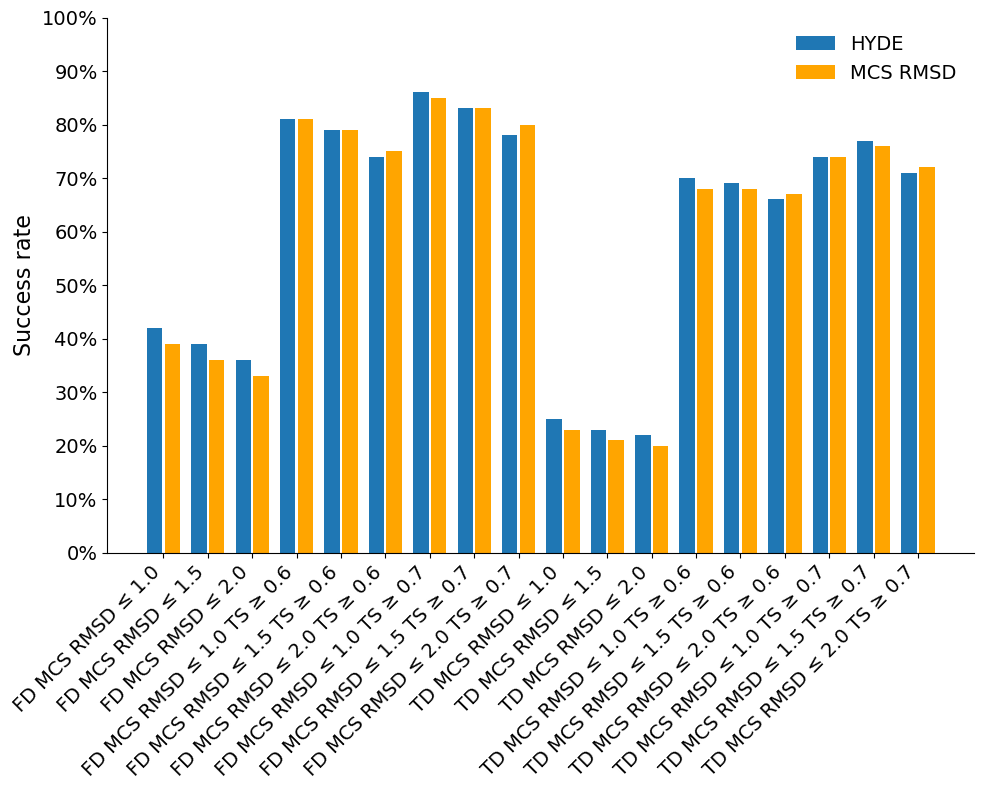

In [25]:
# Prepare data
labels = hyde_vs_mcs.index
hyde = hyde_vs_mcs['HYDE'].values
mcs_rmsd = hyde_vs_mcs['MCS RMSD'].values

x = np.arange(len(labels))  # the label locations
bar_width = 0.35
gap = 0.05  # space between the two bars within a group

fig, ax = plt.subplots(figsize=(10, 8))

# Bars with gap between them
ax.bar(x - bar_width/2 - gap/2, hyde, width=bar_width, label='HYDE')
ax.bar(x + bar_width/2 + gap/2, mcs_rmsd, width=bar_width, label='MCS RMSD', color='orange')

# X-axis labels and ticks
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)

# Y-axis ticks as percentages
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticklabels([f"{int(ytick * 100)}%" for ytick in np.linspace(0, 1, 11)], fontsize=14)

# Labels, legend, spines
ax.set_ylabel("Success rate", fontsize=16)
ax.legend(fontsize=14, frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.tight_layout()
plt.savefig('../images/hyde_vs_mcs.png', dpi=300)

plt.show()


In [23]:
hyde_vs_mcs

,HYDE,MCS RMSD
FD MCS RMSD ≤ 1.0,0.42,0.39
FD MCS RMSD ≤ 1.5,0.39,0.36
FD MCS RMSD ≤ 2.0,0.36,0.33
FD MCS RMSD ≤ 1.0 TS ≥ 0.6,0.81,0.81
FD MCS RMSD ≤ 1.5 TS ≥ 0.6,0.79,0.79
FD MCS RMSD ≤ 2.0 TS ≥ 0.6,0.74,0.75
FD MCS RMSD ≤ 1.0 TS ≥ 0.7,0.86,0.85
FD MCS RMSD ≤ 1.5 TS ≥ 0.7,0.83,0.83
FD MCS RMSD ≤ 2.0 TS ≥ 0.7,0.78,0.80
TD MCS RMSD ≤ 1.0,0.25,0.23


In [27]:
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(hyde_vs_mcs['HYDE'], hyde_vs_mcs['MCS RMSD'])

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 2.2906142364542523
p-value: 0.03503696024019577


Difference is negligible, continue with HYDE as otehr studies

In [24]:
fd_hyde_6 = fd_hyde_score_top1[fd_hyde_score_top1.Tanimoto_Similarity >= 0.6].reset_index(drop=True)
fd_hyde_7 = fd_hyde_score_top1[fd_hyde_score_top1.Tanimoto_Similarity >= 0.7].reset_index(drop=True)

td_hyde_6 = td_hyde_score_top1[td_hyde_score_top1.Tanimoto_Similarity >= 0.6].reset_index(drop=True)
td_hyde_7 = td_hyde_score_top1[td_hyde_score_top1.Tanimoto_Similarity >= 0.7].reset_index(drop=True)


In [25]:
fd_hyde_6_sr = round(len(fd_hyde_6[fd_hyde_6.hyde_rmsd <= 2])/len(fd_hyde_6), 2)
fd_hyde_7_sr = round(len(fd_hyde_7[fd_hyde_7.hyde_rmsd <= 2])/len(fd_hyde_7), 2)

td_hyde_6_sr = round(len(td_hyde_6[td_hyde_6.hyde_rmsd <= 2])/len(td_hyde_6), 2)
td_hyde_7_sr = round(len(td_hyde_7[td_hyde_7.hyde_rmsd <= 2])/len(td_hyde_7), 2)


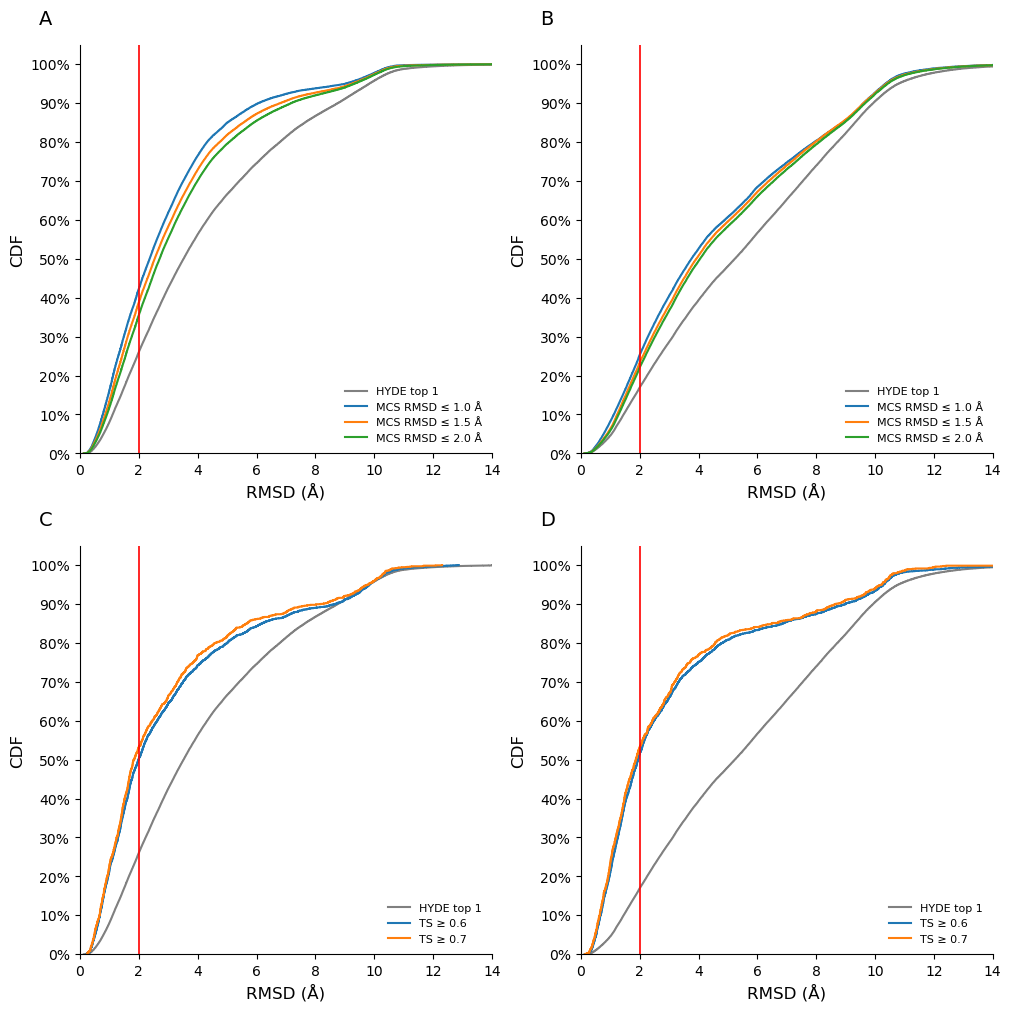

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Optional: define percent y-axis formatting
def percent_formatter(x, pos):
    return f"{int(x * 100)}%"

# Color scheme
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
subplot_tags = ['A', 'B', 'C', 'D']

fig, axes = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)

# FD MCS
ax = axes[0, 0]
ax.ecdf(fd_hyde_score_top1.hyde_rmsd, label='HYDE top 1', color='gray', linewidth=1.5)
ax.ecdf(fd_mcs_10_hs.hyde_rmsd, label='MCS RMSD ≤ 1.0 Å', color=colors[0], linewidth=1.5)
ax.ecdf(fd_mcs_15_hs.hyde_rmsd, label='MCS RMSD ≤ 1.5 Å', color=colors[1], linewidth=1.5)
ax.ecdf(fd_mcs_20_hs.hyde_rmsd, label='MCS RMSD ≤ 2.0 Å', color=colors[2], linewidth=1.5)

# ----- TD MCS -----
ax = axes[0, 1]
ax.ecdf(td_hyde_score_top1.hyde_rmsd, label='HYDE top 1', color='gray', linewidth=1.5)
ax.ecdf(td_mcs_10_hs.hyde_rmsd, label='MCS RMSD ≤ 1.0 Å', color=colors[0], linewidth=1.5)
ax.ecdf(td_mcs_15_hs.hyde_rmsd, label='MCS RMSD ≤ 1.5 Å', color=colors[1], linewidth=1.5)
ax.ecdf(td_mcs_20_hs.hyde_rmsd, label='MCS RMSD ≤ 2.0 Å', color=colors[2], linewidth=1.5)

# FD TS
ax = axes[1, 0]
ax.ecdf(fd_hyde_score_top1.hyde_rmsd, label='HYDE top 1', color='gray', linewidth=1.5)
ax.ecdf(fd_hyde_6.hyde_rmsd, label='TS ≥ 0.6', color=colors[0], linewidth=1.5)
ax.ecdf(fd_hyde_7.hyde_rmsd, label='TS ≥ 0.7', color=colors[1], linewidth=1.5)

# TD TS
ax = axes[1, 1]
ax.ecdf(td_hyde_score_top1.hyde_rmsd, label='HYDE top 1', color='gray', linewidth=1.5)
ax.ecdf(td_hyde_6.hyde_rmsd, label='TS ≥ 0.6', color=colors[0], linewidth=1.5)
ax.ecdf(td_hyde_7.hyde_rmsd, label='TS ≥ 0.7', color=colors[1], linewidth=1.5)

# Format all subplots
for i, ax in enumerate(axes.flat):
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 1.05)
    ax.axvline(x=2, color='red', linewidth=1.2)
    ax.set_xlabel("RMSD (Å)", fontsize=12)
    ax.set_ylabel("CDF", fontsize=12)
    ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    ax.set_yticks(np.linspace(0, 1, 11))
    ax.tick_params(labelsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.text(-0.1, 1.05, subplot_tags[i], fontsize=14, transform=ax.transAxes)
    ax.legend(fontsize=8, frameon=False, loc='lower right')

# Save and show
plt.savefig('../images/cross_docking_mcs_and_ts_ecdf.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
fd_mcs_10_hs.hyde_rmsd
fd_mcs_15_hs.hyde_rmsd
fd_mcs_20_hs.hyde_rmsd

td_mcs_10_hs.hyde_rmsd
td_mcs_15_hs.hyde_rmsd
td_mcs_20_hs.hyde_rmsd

fd_hyde_6.hyde_rmsd
fd_hyde_7.hyde_rmsd

td_hyde_6.hyde_rmsd
td_hyde_7.hyde_rmsd

In [26]:
all_dfs = {
    'fd_mcs_10': fd_mcs_10_hs,
    'fd_mcs_15': fd_mcs_15_hs,
    'fd_mcs_20': fd_mcs_20_hs,
    'td_mcs_10': td_mcs_10_hs,
    'td_mcs_15': td_mcs_15_hs,
    'td_mcs_20': td_mcs_20_hs,
    'fd_hyde_6': fd_hyde_6,
    'fd_hyde_7': fd_hyde_7,
    'td_hyde_6': td_hyde_6,
    'td_hyde_7': td_hyde_7
}

# Compute success rates
results = []

for name, df in all_dfs.items():
    rmsd_values = df['hyde_rmsd'].dropna()
    total = len(rmsd_values)
    success = (rmsd_values <= 2.0).sum()
    success_rate = success / total if total > 0 else 0
    results.append({'Method': name, 'Success Rate (%)': round(success_rate * 100, 2), 'N': total})

# Create a summary DataFrame
summary_df = pd.DataFrame(results).sort_values(by='Success Rate (%)', ascending=False)

# Optional: Add columns for method type
summary_df['Docking Type'] = summary_df['Method'].apply(lambda x: 'Free Docking' if x.startswith('fd') else 'Template-Based')

summary_df

,Method,Success Rate (%),N,Docking Type
7,fd_hyde_7,53.28,1282,Free Docking
9,td_hyde_7,53.20,1250,Template-Based
8,td_hyde_6,51.55,2782,Template-Based
6,fd_hyde_6,50.37,2851,Free Docking
0,fd_mcs_10,42.28,60684,Free Docking
1,fd_mcs_15,38.82,81777,Free Docking
2,fd_mcs_20,35.55,97572,Free Docking
3,td_mcs_10,25.31,57335,Template-Based
4,td_mcs_15,23.32,76506,Template-Based
5,td_mcs_20,22.06,82855,Template-Based


In [31]:
sr_df = pd.DataFrame(columns=['Poses', '% of total', 'Success Rate', 
                              'Poses', '% of total', 'Success Rate'], 
                     index=['Free Docking', 'Hyde score', 'MCS RMSD 1.0', 'MCS RMSD 1.5', 'MCS RMSD 2.0',
                            'Template Based Docking', 'Hyde score', 'MCS RMSD 1.0', 'MCS RMSD 1.5', 'MCS RMSD 2.0'])
sr_df

,Poses,% of total,Success Rate,Poses,% of total,Success Rate
Free Docking,NaN,NaN,NaN,NaN,NaN,NaN
Hyde score,NaN,NaN,NaN,NaN,NaN,NaN
MCS RMSD 1.0,NaN,NaN,NaN,NaN,NaN,NaN
MCS RMSD 1.5,NaN,NaN,NaN,NaN,NaN,NaN
MCS RMSD 2.0,NaN,NaN,NaN,NaN,NaN,NaN
Template Based Docking,NaN,NaN,NaN,NaN,NaN,NaN
Hyde score,NaN,NaN,NaN,NaN,NaN,NaN
MCS RMSD 1.0,NaN,NaN,NaN,NaN,NaN,NaN
MCS RMSD 1.5,NaN,NaN,NaN,NaN,NaN,NaN
MCS RMSD 2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
sr_df.iloc[1, 0] = len(fd_hyde_6)
sr_df.iloc[1, 1] = round(len(fd_hyde_6)/ts_6_pairs, 2)
sr_df.iloc[1, 2] = fd_hyde_6_sr

sr_df.iloc[1, 3] = len(fd_hyde_7)
sr_df.iloc[1, 4] = round(len(fd_hyde_7)/ts_7_pairs, 2)
sr_df.iloc[1, 5] = fd_hyde_7_sr

sr_df.iloc[2, 0] = len(fd_mcs_10_6_hs)
sr_df.iloc[2, 1] = round(len(fd_mcs_10_6_hs)/ts_6_pairs, 2)
sr_df.iloc[2, 2] = fd_mcs_10_6_hs_sr

sr_df.iloc[2, 3] = len(fd_mcs_10_7_hs)
sr_df.iloc[2, 4] = round(len(fd_mcs_10_7_hs)/ts_7_pairs, 2)
sr_df.iloc[2, 5] = fd_mcs_10_7_hs_sr


sr_df.iloc[3, 0] = len(fd_mcs_15_6_hs)
sr_df.iloc[3, 1] = round(len(fd_mcs_15_6_hs)/ts_6_pairs, 2)
sr_df.iloc[3, 2] = fd_mcs_15_6_hs_sr

sr_df.iloc[3, 3] = len(fd_mcs_15_7_hs)
sr_df.iloc[3, 4] = round(len(fd_mcs_15_7_hs)/ts_7_pairs, 2)
sr_df.iloc[3, 5] = fd_mcs_15_7_hs_sr

sr_df.iloc[4, 0] = len(fd_mcs_20_6_hs)
sr_df.iloc[4, 1] = round(len(fd_mcs_20_6_hs)/ts_6_pairs, 2)
sr_df.iloc[4, 2] = fd_mcs_20_6_hs_sr

sr_df.iloc[4, 3] = len(fd_mcs_20_7_hs)
sr_df.iloc[4, 4] = round(len(fd_mcs_20_7_hs)/ts_7_pairs, 2)
sr_df.iloc[4, 5] = fd_mcs_20_7_hs_sr

sr_df.iloc[6, 0] = len(td_hyde_6)
sr_df.iloc[6, 1] = round(len(td_hyde_6)/ts_6_pairs, 2)
sr_df.iloc[6, 2] = td_hyde_6_sr

sr_df.iloc[6, 3] = len(td_hyde_7)
sr_df.iloc[6, 4] = round(len(td_hyde_7)/ts_7_pairs, 2)
sr_df.iloc[6, 5] = td_hyde_7_sr

sr_df.iloc[7, 0] = len(td_mcs_10_6_hs)
sr_df.iloc[7, 1] = round(len(td_mcs_10_6_hs)/ts_6_pairs, 2)
sr_df.iloc[7, 2] = td_mcs_10_6_hs_sr

sr_df.iloc[7, 3] = len(td_mcs_10_7_hs)
sr_df.iloc[7, 4] = round(len(td_mcs_10_7_hs)/ts_7_pairs, 2)
sr_df.iloc[7, 5] = td_mcs_10_7_hs_sr

sr_df.iloc[8, 0] = len(td_mcs_15_6_hs)
sr_df.iloc[8, 1] = round(len(td_mcs_15_6_hs)/ts_6_pairs, 2)
sr_df.iloc[8, 2] = td_mcs_15_6_hs_sr

sr_df.iloc[8, 3] = len(td_mcs_15_7_hs)
sr_df.iloc[8, 4] = round(len(td_mcs_15_7_hs)/ts_7_pairs, 2)
sr_df.iloc[8, 5] = td_mcs_15_7_hs_sr

sr_df.iloc[9, 0] = len(td_mcs_20_6_hs)
sr_df.iloc[9, 1] = round(len(td_mcs_20_6_hs)/ts_6_pairs, 2)
sr_df.iloc[9, 2] = td_mcs_20_6_hs_sr

sr_df.iloc[9, 3] = len(td_mcs_20_7_hs)
sr_df.iloc[9, 4] = round(len(td_mcs_20_7_hs)/ts_7_pairs, 2)
sr_df.iloc[9, 5] = td_mcs_20_7_hs_sr

In [33]:
sr_df

,Poses,% of total,Success Rate,Poses,% of total,Success Rate
Free Docking,NaN,NaN,NaN,NaN,NaN,NaN
Hyde score,2851,0.95,0.5,1282,0.97,0.53
MCS RMSD 1.0,1360,0.46,0.81,607,0.46,0.86
MCS RMSD 1.5,1752,0.59,0.79,795,0.6,0.83
MCS RMSD 2.0,2026,0.68,0.74,916,0.69,0.78
Template Based Docking,NaN,NaN,NaN,NaN,NaN,NaN
Hyde score,2782,0.93,0.52,1250,0.94,0.53
MCS RMSD 1.0,1405,0.47,0.7,588,0.44,0.77
MCS RMSD 1.5,1708,0.57,0.69,737,0.56,0.74
MCS RMSD 2.0,1848,0.62,0.66,799,0.6,0.71


# Success rate plots

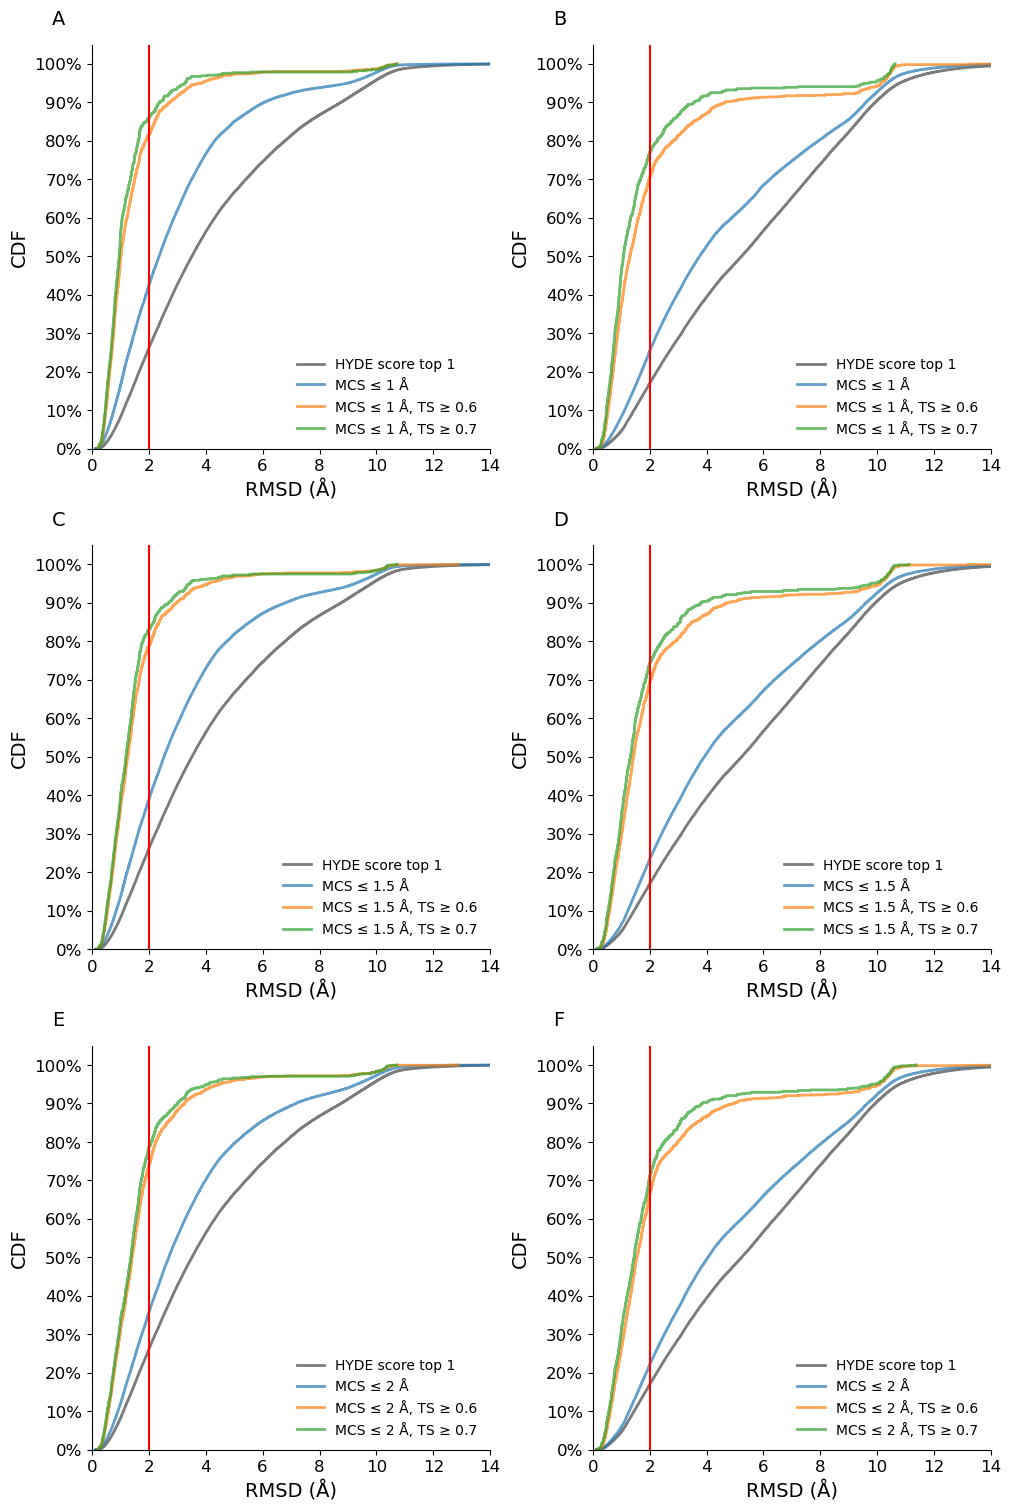

In [34]:
# Formatter for Y-axis to show percentages
def percent_formatter(x, pos):
    return f"{int(x * 100)}%"

# Labels
mcs_labels = ['MCS ≤ 1 Å', 'MCS ≤ 1.5 Å', 'MCS ≤ 2 Å']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
subplot_tags = ['A', 'B', 'C', 'D', 'E', 'F']
bl_color = '#444444'

fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)

# FD MCS 1.0
ax = axes[0, 0]
ax.ecdf(fd_hyde_score_top1.hyde_rmsd, label='HYDE score top 1', color=bl_color, linewidth=2, alpha=0.7)
ax.ecdf(fd_mcs_10_hs.hyde_rmsd, label='MCS ≤ 1 Å', color=colors[0], linewidth=2, alpha=0.7)
ax.ecdf(fd_mcs_10_6_hs.hyde_rmsd, label='MCS ≤ 1 Å, TS ≥ 0.6', color=colors[1], linewidth=2, alpha=0.7)
ax.ecdf(fd_mcs_10_7_hs.hyde_rmsd, label='MCS ≤ 1 Å, TS ≥ 0.7', color=colors[2], linewidth=2, alpha=0.7)

# TBD MCS 1.0
ax = axes[0, 1]
ax.ecdf(td_hyde_score_top1.hyde_rmsd, label='HYDE score top 1', color=bl_color, linewidth=2, alpha=0.7)
ax.ecdf(td_mcs_10_hs.hyde_rmsd, label='MCS ≤ 1 Å', color=colors[0], linewidth=2, alpha=0.7)
ax.ecdf(td_mcs_10_6_hs.hyde_rmsd, label='MCS ≤ 1 Å, TS ≥ 0.6', color=colors[1], linewidth=2, alpha=0.7)
ax.ecdf(td_mcs_10_7_hs.hyde_rmsd, label='MCS ≤ 1 Å, TS ≥ 0.7', color=colors[2], linewidth=2, alpha=0.7)

# FD MCS 1.5 
ax = axes[1, 0]
ax.ecdf(fd_hyde_score_top1.hyde_rmsd, label='HYDE score top 1', color=bl_color, linewidth=2, alpha=0.7)
ax.ecdf(fd_mcs_15_hs.hyde_rmsd, label='MCS ≤ 1.5 Å', color=colors[0], linewidth=2, alpha=0.7)
ax.ecdf(fd_mcs_15_6_hs.hyde_rmsd, label='MCS ≤ 1.5 Å, TS ≥ 0.6', color=colors[1], linewidth=2, alpha=0.7)
ax.ecdf(fd_mcs_15_7_hs.hyde_rmsd, label='MCS ≤ 1.5 Å, TS ≥ 0.7', color=colors[2], linewidth=2, alpha=0.7)

# TBD MCS 1.5
ax = axes[1, 1]
ax.ecdf(td_hyde_score_top1.hyde_rmsd, label='HYDE score top 1', color=bl_color, linewidth=2, alpha=0.7)
ax.ecdf(td_mcs_15_hs.hyde_rmsd, label='MCS ≤ 1.5 Å', color=colors[0], linewidth=2, alpha=0.7)
ax.ecdf(td_mcs_15_6_hs.hyde_rmsd, label='MCS ≤ 1.5 Å, TS ≥ 0.6', color=colors[1], linewidth=2, alpha=0.7)
ax.ecdf(td_mcs_15_7_hs.hyde_rmsd, label='MCS ≤ 1.5 Å, TS ≥ 0.7', color=colors[2], linewidth=2, alpha=0.7)

# FD MCS 2.0 
ax = axes[2, 0]
ax.ecdf(fd_hyde_score_top1.hyde_rmsd, label='HYDE score top 1', color=bl_color, linewidth=2, alpha=0.7)
ax.ecdf(fd_mcs_20_hs.hyde_rmsd, label='MCS ≤ 2 Å', color=colors[0], linewidth=2, alpha=0.7)
ax.ecdf(fd_mcs_20_6_hs.hyde_rmsd, label='MCS ≤ 2 Å, TS ≥ 0.6', color=colors[1], linewidth=2, alpha=0.7)
ax.ecdf(fd_mcs_20_7_hs.hyde_rmsd, label='MCS ≤ 2 Å, TS ≥ 0.7', color=colors[2], linewidth=2, alpha=0.7)

# TBD MCS 2.0
ax = axes[2, 1]
ax.ecdf(td_hyde_score_top1.hyde_rmsd, label='HYDE score top 1', color=bl_color, linewidth=2, alpha=0.7)
ax.ecdf(td_mcs_20_hs.hyde_rmsd, label='MCS ≤ 2 Å', color=colors[0], linewidth=2, alpha=0.7)
ax.ecdf(td_mcs_20_6_hs.hyde_rmsd, label='MCS ≤ 2 Å, TS ≥ 0.6', color=colors[1], linewidth=2, alpha=0.7)
ax.ecdf(td_mcs_20_7_hs.hyde_rmsd, label='MCS ≤ 2 Å, TS ≥ 0.7', color=colors[2], linewidth=2, alpha=0.7)

for i, ax in enumerate(axes.flat):
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 1.05)
    ax.axvline(x=2, color='red', linestyle='-')

    ax.set_xlabel("RMSD (Å)", fontsize=14)
    ax.set_ylabel("CDF", fontsize=14)

    ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    ax.set_yticks(np.linspace(0, 1, 11))

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.text(-0.1, 1.05, subplot_tags[i], fontsize=14, transform=ax.transAxes)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    ax.legend(fontsize=10, frameon=False, loc='lower right')

# Save and show
plt.savefig("../images/cross_docking_mcs_ts.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()


# Success rates par target

In [35]:
target_sr_cols = ['FD Top 1 Hyde', 'FD MCS RMSD ≤ 1.0', 'FD MCS RMSD ≤ 1.0 TS ≥ 0.6', 'FD MCS RMSD ≤ 1.0 TS ≥ 0.7',
                  'FD MCS RMSD ≤ 1.5', 'FD MCS RMSD ≤ 1.5 TS ≥ 0.6', 'FD MCS RMSD ≤ 1.5 TS ≥ 0.7', 
                  'FD MCS RMSD ≤ 2.0', 'FD MCS RMSD ≤ 2.0 TS ≥ 0.6', 'FD MCS RMSD ≤ 2.0 TS ≥ 0.7', 
                  'TBD Top 1 Hyde', 'TBD MCS RMSD ≤ 1.0', 'TBD MCS RMSD ≤ 1.0 TS ≥ 0.6',
                  'TBD MCS RMSD ≤ 1.0 TS ≥ 0.7', 'TBD MCS RMSD ≤ 1.5', 'TBD MCS RMSD ≤ 1.5 TS ≥ 0.6',
                  'TBD MCS RMSD ≤ 1.5 TS ≥ 0.7', 'TBD MCS RMSD ≤ 2.0', 'TBD MCS RMSD ≤ 2.0 TS ≥ 0.6',
                  'TBD MCS RMSD ≤ 2.0 TS ≥ 0.7']

target_sr = pd.DataFrame(columns=target_sr_cols, dtype=float)
lig_left = pd.DataFrame(columns=target_sr_cols, dtype=float)

In [36]:
col_df_dict = {'FD Top 1 Hyde':     fd_hyde_score_top1,
               'FD MCS RMSD ≤ 1.0': fd_mcs_10_hs,
               'FD MCS RMSD ≤ 1.5': fd_mcs_15_hs,
               'FD MCS RMSD ≤ 2.0': fd_mcs_20_hs,

               'FD MCS RMSD ≤ 1.0 TS ≥ 0.6': fd_mcs_10_6_hs,
               'FD MCS RMSD ≤ 1.5 TS ≥ 0.6': fd_mcs_15_6_hs,
               'FD MCS RMSD ≤ 2.0 TS ≥ 0.6': fd_mcs_20_6_hs,

               'FD MCS RMSD ≤ 1.0 TS ≥ 0.7': fd_mcs_10_7_hs,
               'FD MCS RMSD ≤ 1.5 TS ≥ 0.7': fd_mcs_15_7_hs,
               'FD MCS RMSD ≤ 2.0 TS ≥ 0.7': fd_mcs_20_7_hs,
               
               'TBD Top 1 Hyde':     td_hyde_score_top1,
               'TBD MCS RMSD ≤ 1.0': td_mcs_10_hs,
               'TBD MCS RMSD ≤ 1.5': td_mcs_15_hs,
               'TBD MCS RMSD ≤ 2.0': td_mcs_20_hs,
    
               'TBD MCS RMSD ≤ 1.0 TS ≥ 0.6': td_mcs_10_6_hs,
               'TBD MCS RMSD ≤ 1.5 TS ≥ 0.6': td_mcs_15_6_hs,
               'TBD MCS RMSD ≤ 2.0 TS ≥ 0.6': td_mcs_20_6_hs,

               'TBD MCS RMSD ≤ 1.0 TS ≥ 0.7': td_mcs_10_7_hs,
               'TBD MCS RMSD ≤ 1.5 TS ≥ 0.7': td_mcs_15_7_hs,
               'TBD MCS RMSD ≤ 2.0 TS ≥ 0.7': td_mcs_20_7_hs}

In [37]:
similarity_df = pd.DataFrame(columns=['Ligands', 'TS_6', 'TS_7'], index=count_df.UniProt_ID.to_list())
for uni in count_df.UniProt_ID:

    target_df = astex[astex.UniProt_ID == uni]
    similarity_df.loc[uni, 'Ligands'] = len(target_df)
    target_lig_list = target_df.Template.unique()
    
    target_simmat = similarity_matrix.loc[target_lig_list, target_lig_list]

    # Initialize an empty set to store molecules with TS >= 0.6
    ts6 = set()
    ts7 = set()

    for mol1 in target_simmat.index:
        # Exclude the diagonal by dropping the mol1 column for this row
        similarities = target_simmat.loc[mol1].drop(mol1)
        # Check if any value meets the threshold
        if (similarities >= 0.6).any():
            ts6.add(mol1)
        if (similarities >= 0.7).any():
            ts7.add(mol1)
            
    similarity_df.loc[uni, 'TS_6'] = len(ts6)
    similarity_df.loc[uni, 'TS_7'] = len(ts7)


In [38]:
for i, uni in enumerate(uniprots):
    for col in target_sr.columns:
        if '0.6' in col:
            if count_df[count_df.UniProt_ID == uni].TS_6.iloc[0] == 0:
                target_sr.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                if target_df.empty:
                    target_sr.loc[uni, str(col)] = -2
                else:
                    target_sr.loc[uni, str(col)] = round(len(target_df[target_df.hyde_rmsd <= 2])/len(target_df), 2)*100
                    
        elif '0.7' in col:
            if count_df[count_df.UniProt_ID == uni].TS_7.iloc[0] == 0:
                target_sr.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                if target_df.empty:
                    target_sr.loc[uni, str(col)] = -2
                else:
                    target_sr.loc[uni, str(col)] = round(len(target_df[target_df.hyde_rmsd <= 2])/len(target_df), 2)*100
        else:
            target_df = col_df_dict[col]
            target_df = target_df[target_df.UniProt_ID == uni]
            if target_df.empty:
                target_sr.loc[uni, str(col)] = -2
            else:
                target_sr.loc[uni, str(col)] = round(len(target_df[target_df.hyde_rmsd <= 2])/len(target_df), 2)*100
            
target_sr

,FD Top 1 Hyde,FD MCS RMSD ≤ 1.0,FD MCS RMSD ≤ 1.0 TS ≥ 0.6,FD MCS RMSD ≤ 1.0 TS ≥ 0.7,FD MCS RMSD ≤ 1.5,FD MCS RMSD ≤ 1.5 TS ≥ 0.6,FD MCS RMSD ≤ 1.5 TS ≥ 0.7,FD MCS RMSD ≤ 2.0,FD MCS RMSD ≤ 2.0 TS ≥ 0.6,FD MCS RMSD ≤ 2.0 TS ≥ 0.7,TBD Top 1 Hyde,TBD MCS RMSD ≤ 1.0,TBD MCS RMSD ≤ 1.0 TS ≥ 0.6,TBD MCS RMSD ≤ 1.0 TS ≥ 0.7,TBD MCS RMSD ≤ 1.5,TBD MCS RMSD ≤ 1.5 TS ≥ 0.6,TBD MCS RMSD ≤ 1.5 TS ≥ 0.7,TBD MCS RMSD ≤ 2.0,TBD MCS RMSD ≤ 2.0 TS ≥ 0.6,TBD MCS RMSD ≤ 2.0 TS ≥ 0.7
O14757,44.0,46.0,86.0,100.0,48.0,89.0,100.0,48.0,89.0,100.0,16.0,28.0,84.0,100.0,24.0,84.0,100.0,24.0,84.0,100.0
O43570,39.0,42.0,100.0,-2.0,45.0,86.0,50.0,41.0,88.0,50.0,26.0,24.0,100.0,100.0,31.0,80.0,100.0,29.0,80.0,100.0
O76074,30.0,56.0,64.0,73.0,47.0,57.0,58.0,43.0,54.0,52.0,23.0,54.0,40.0,67.0,44.0,33.0,50.0,40.0,25.0,33.0
P00183,-2.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0
P00374,24.0,27.0,100.0,100.0,30.0,100.0,100.0,31.0,100.0,100.0,17.0,17.0,80.0,100.0,20.0,83.0,100.0,21.0,83.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q24451,28.0,52.0,100.0,100.0,45.0,100.0,100.0,45.0,92.0,83.0,21.0,50.0,100.0,100.0,49.0,100.0,100.0,36.0,92.0,100.0
Q54276,17.0,50.0,-1.0,-1.0,50.0,-1.0,-1.0,50.0,-1.0,-1.0,57.0,57.0,-1.0,-1.0,57.0,-1.0,-1.0,57.0,-1.0,-1.0
Q79MP6,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,50.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
Q8I3X4,83.0,100.0,-1.0,-1.0,100.0,-1.0,-1.0,83.0,-1.0,-1.0,83.0,100.0,-1.0,-1.0,100.0,-1.0,-1.0,100.0,-1.0,-1.0


In [40]:
for i, uni in enumerate(uniprots):
    for col in lig_left.columns:

        if '0.6' in col:
            if similarity_df.loc[uni].TS_6 == 0:
                lig_left.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                if target_df.empty:
                    lig_left.loc[uni, str(col)] = -2
                else:
                    ligs = similarity_df.loc[uni].TS_6
                    lig_left.loc[uni, str(col)] = int(len(target_df[target_df.hyde_rmsd <= 2].Docked.unique()))
                    
        elif '0.7' in col:
            if similarity_df.loc[uni].TS_7 == 0:
                lig_left.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                if target_df.empty:
                    lig_left.loc[uni, str(col)] = -2
                else:
                    ligs = similarity_df.loc[uni].TS_7
                    lig_left.loc[uni, str(col)] = int(len(target_df[target_df.hyde_rmsd <= 2].Docked.unique()))
        else:
            target_df = col_df_dict[col]
            target_df = target_df[target_df.UniProt_ID == uni]
            if target_df.empty:
                lig_left.loc[uni, str(col)] = -2
            else:
                ligs = similarity_df.loc[uni].Ligands
                lig_left.loc[uni, str(col)] = int(len(target_df[target_df.hyde_rmsd <= 2].Docked.unique()))
lig_left

,FD Top 1 Hyde,FD MCS RMSD ≤ 1.0,FD MCS RMSD ≤ 1.0 TS ≥ 0.6,FD MCS RMSD ≤ 1.0 TS ≥ 0.7,FD MCS RMSD ≤ 1.5,FD MCS RMSD ≤ 1.5 TS ≥ 0.6,FD MCS RMSD ≤ 1.5 TS ≥ 0.7,FD MCS RMSD ≤ 2.0,FD MCS RMSD ≤ 2.0 TS ≥ 0.6,FD MCS RMSD ≤ 2.0 TS ≥ 0.7,TBD Top 1 Hyde,TBD MCS RMSD ≤ 1.0,TBD MCS RMSD ≤ 1.0 TS ≥ 0.6,TBD MCS RMSD ≤ 1.0 TS ≥ 0.7,TBD MCS RMSD ≤ 1.5,TBD MCS RMSD ≤ 1.5 TS ≥ 0.6,TBD MCS RMSD ≤ 1.5 TS ≥ 0.7,TBD MCS RMSD ≤ 2.0,TBD MCS RMSD ≤ 2.0 TS ≥ 0.6,TBD MCS RMSD ≤ 2.0 TS ≥ 0.7
O14757,69.0,54.0,21.0,8.0,64.0,26.0,13.0,66.0,26.0,13.0,68.0,55.0,20.0,7.0,56.0,20.0,7.0,57.0,20.0,7.0
O43570,9.0,7.0,4.0,-2.0,9.0,6.0,1.0,9.0,6.0,1.0,10.0,6.0,4.0,1.0,8.0,4.0,1.0,8.0,4.0,1.0
O76074,11.0,9.0,4.0,4.0,9.0,4.0,4.0,9.0,4.0,4.0,8.0,8.0,2.0,2.0,8.0,3.0,3.0,8.0,3.0,3.0
P00183,-2.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0
P00374,19.0,17.0,6.0,3.0,17.0,7.0,3.0,17.0,8.0,4.0,18.0,14.0,4.0,2.0,15.0,5.0,2.0,15.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q24451,27.0,21.0,5.0,2.0,23.0,5.0,3.0,26.0,5.0,3.0,25.0,12.0,7.0,5.0,12.0,7.0,5.0,12.0,7.0,5.0
Q54276,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,2.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0
Q79MP6,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
Q8I3X4,3.0,3.0,-1.0,-1.0,3.0,-1.0,-1.0,3.0,-1.0,-1.0,3.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0


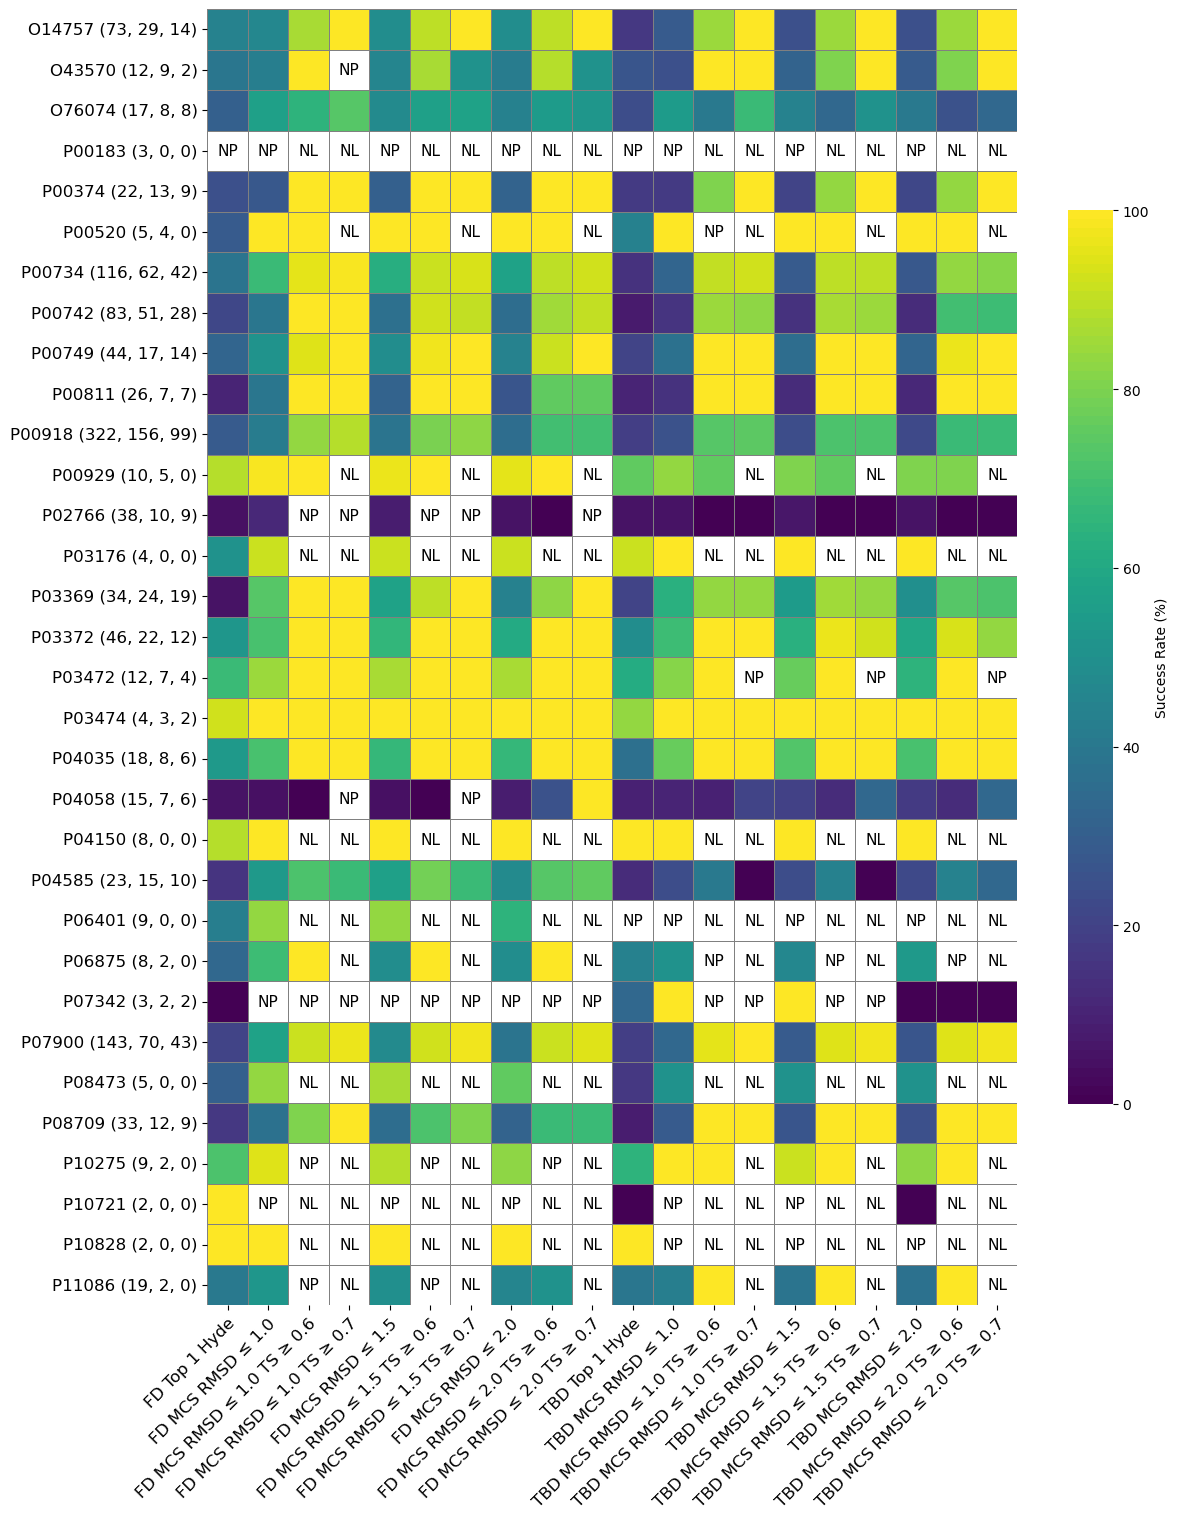

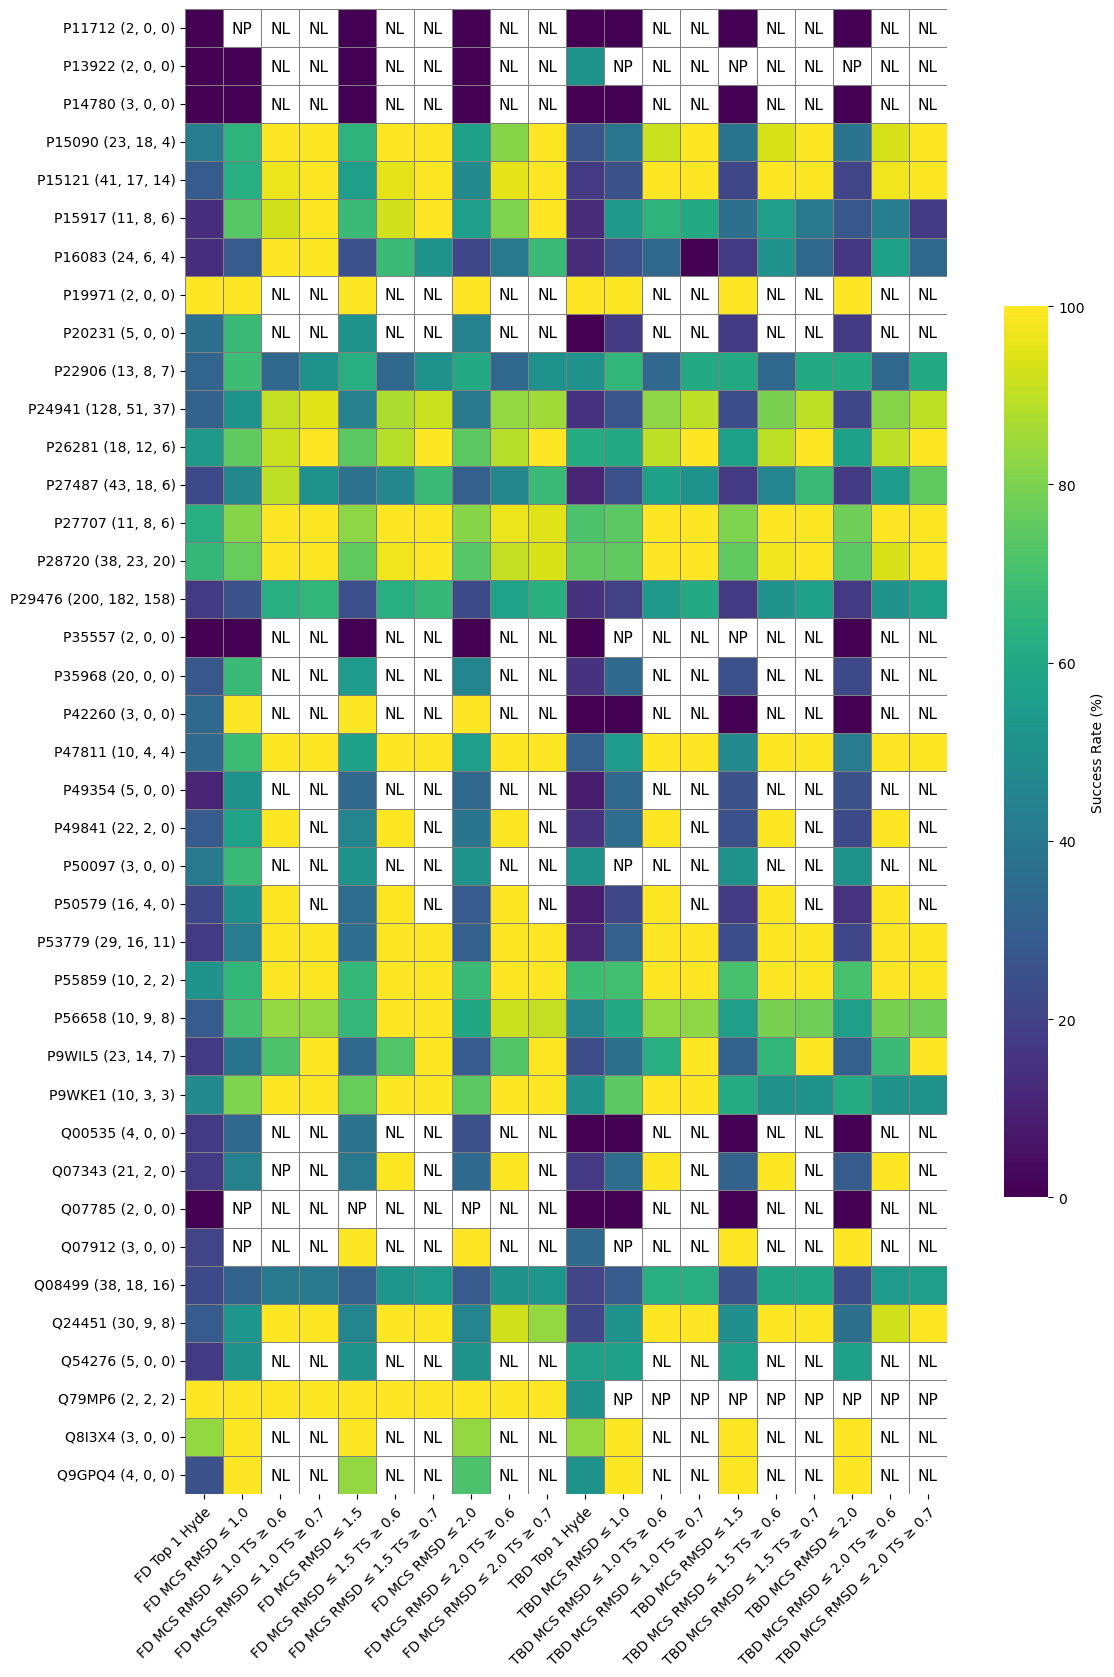

In [427]:
df_colored = target_sr.map(lambda x: np.nan if x in [-2, -1] else x)


df_colored.index = [f'{i} ({similarity_df.loc[i].Ligands}, {similarity_df.loc[i].TS_6}, {similarity_df.loc[i].TS_7})' for i in df_colored.index]

colors = list(sns.color_palette("viridis", as_cmap=True)(np.linspace(0, 1, 100)))
cmap = ListedColormap(colors)

def add_white_cells_with_annotations(ax, df_ex, target_sr):
    for (i, j), val in np.ndenumerate(df_ex.values):
        if val == -1:
            ax.text(j + 0.5, i + 0.5, 'NL', color='black', ha='center', va='center', fontsize=11)
        elif val == -2:
            ax.text(j + 0.5, i + 0.5, 'NP', color='black', ha='center', va='center', fontsize=11)
#         else:
#             if target_sr.iloc[i, j] > 70:
#                 ax.text(j + 0.5, i + 0.5, int(val), color='black', ha='center', va='center', fontsize=11)
#             else:
#                 ax.text(j + 0.5, i + 0.5, int(val), color='white', ha='center', va='center', fontsize=11)

# === First heatmap ===
fig1, ax1 = plt.subplots(figsize=(12.4, 16.88))
sns.heatmap(
    df_colored.iloc[:32, :],
    ax=ax1,
    cmap=cmap,
    annot=False,
    cbar=True,
    vmin=0,
    vmax=100,
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={'label': 'Success Rate (%)', 'shrink': 0.6, "orientation": "vertical"}
)
add_white_cells_with_annotations(ax1, lig_left.iloc[:32, :], target_sr.iloc[:32, :])
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
plt.tight_layout()
# Save first image
plt.savefig("../images/success_rate_per_target_part1.png", dpi=300, bbox_inches='tight')
plt.show()

fig2, ax2 = plt.subplots(figsize=(12.4, 16.88))
sns.heatmap(
    df_colored.iloc[32:, :],
    ax=ax2,
    cmap=cmap,
    annot=False,
    cbar=True,
    vmin=0,
    vmax=100,
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={'label': 'Success Rate (%)', 'shrink': 0.6, "orientation": "vertical"}
)
add_white_cells_with_annotations(ax2, lig_left.iloc[32:, :], target_sr.iloc[32:, :])
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax3.set_xticklabels(ax2.get_xticklabels(), fontsize=12)
ax3.set_yticklabels(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
# Save second image
plt.savefig("../images/success_rate_per_target_part2.png", dpi=300, bbox_inches='tight')
plt.show()



# Remove duplicated ligands and recalculate success rates only with highest TS

In [327]:
def compute_sr(df):
    sr_all = round((df.hyde_rmsd <= 2).mean(), 2)*100
    df_unique = df.loc[df.groupby('Docked')['Tanimoto_Similarity'].idxmax()]
    sr_unique = round((df_unique.hyde_rmsd <= 2).mean(), 2)*100
    return sr_all, sr_unique, len(df_unique)

datasets = [
    ('FREE DOCKING TS 6', fd_hyde_6),
    ('FREE DOCKING TS 6 MCS 1.0', fd_mcs_10_6_hs),
    ('FREE DOCKING TS 6 MCS 1.5', fd_mcs_15_6_hs),
    ('FREE DOCKING TS 6 MCS 2.0', fd_mcs_20_6_hs),
    ('TEMPLATE DOCKING TS 6', td_hyde_6),
    ('TEMPLATE DOCKING TS 6 MCS 1.0', td_mcs_10_6_hs),
    ('TEMPLATE DOCKING TS 6 MCS 1.5', td_mcs_15_6_hs),
    ('TEMPLATE DOCKING TS 6 MCS 2.0', td_mcs_20_6_hs),
    ('FREE DOCKING TS 7', fd_hyde_7),
    ('FREE DOCKING TS 7 MCS 1.0', fd_mcs_10_7_hs),
    ('FREE DOCKING TS 7 MCS 1.5', fd_mcs_15_7_hs),
    ('FREE DOCKING TS 7 MCS 2.0', fd_mcs_20_7_hs),
    ('TEMPLATE DOCKING TS 7', td_hyde_7),
    ('TEMPLATE DOCKING TS 7 MCS 1.0', td_mcs_10_7_hs),
    ('TEMPLATE DOCKING TS 7 MCS 1.5', td_mcs_15_7_hs),
    ('TEMPLATE DOCKING TS 7 MCS 2.0', td_mcs_20_7_hs),
]

results = []

for label, df in datasets:
    sr_all, sr_unique, unique_sample = compute_sr(df)
    total_samples = len(df)
    results.append({
        'Dataset': label,
        'Total Ligands': total_samples,
        'Success Rate (All)': sr_all,
        'Unique Ligands': unique_sample,
        'Success Rate (Unique)': sr_unique
    })

sr_unique = pd.DataFrame(results)

sr_unique


,Dataset,Total Ligands,Success Rate (All),Unique Ligands,Success Rate (Unique)
0,FREE DOCKING TS 6,2851,50.0,944,50.0
1,FREE DOCKING TS 6 MCS 1.0,1360,81.0,571,82.0
2,FREE DOCKING TS 6 MCS 1.5,1752,79.0,683,78.0
3,FREE DOCKING TS 6 MCS 2.0,2026,74.0,755,73.0
4,TEMPLATE DOCKING TS 6,2782,52.0,930,56.0
5,TEMPLATE DOCKING TS 6 MCS 1.0,1405,70.0,614,76.0
6,TEMPLATE DOCKING TS 6 MCS 1.5,1708,69.0,686,74.0
7,TEMPLATE DOCKING TS 6 MCS 2.0,1848,66.0,714,72.0
8,FREE DOCKING TS 7,1282,53.0,648,52.0
9,FREE DOCKING TS 7 MCS 1.0,607,86.0,361,85.0


In [421]:
pair_left = pd.DataFrame(columns=target_sr_cols, dtype=float)

for i, uni in enumerate(uniprots):
    for col in pair_left.columns:
        if '0.6' in col:
            if count_df[count_df.UniProt_ID == uni].TS_6.iloc[0] == 0:
                pair_left.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                target_df = target_df.loc[target_df.groupby('Docked')['Tanimoto_Similarity'].idxmax()]
                if target_df.empty:
                    pair_left.loc[uni, str(col)] = -2
                else:
                    lig_pairs = count_df[count_df.UniProt_ID == uni]['TS_6'].iloc[0]
                    total_pairs = lig_pairs
                    pair_left.loc[uni, str(col)] = round(len(target_df[target_df.hyde_rmsd <= 2])/len(target_df), 2)*100
                    
        elif '0.7' in col:
            if count_df[count_df.UniProt_ID == uni].TS_7.iloc[0] == 0:
                pair_left.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                target_df = target_df.loc[target_df.groupby('Docked')['Tanimoto_Similarity'].idxmax()]
                if target_df.empty:
                    pair_left.loc[uni, str(col)] = -2
                else:
                    lig_pairs = count_df[count_df.UniProt_ID == uni]['TS_7'].iloc[0]
                    total_pairs = lig_pairs
                    pair_left.loc[uni, str(col)] = round(len(target_df[target_df.hyde_rmsd <= 2])/len(target_df), 2)*100
        else:
            target_df = col_df_dict[col]
            target_df = target_df[target_df.UniProt_ID == uni]
            target_df = target_df.loc[target_df.groupby('Docked')['Tanimoto_Similarity'].idxmax()]
            if target_df.empty:
                pair_left.loc[uni, str(col)] = -2
            else:
                lig_pairs = count_df[count_df.UniProt_ID == uni]['count'].iloc[0]
                total_pairs = lig_pairs-1
                pair_left.loc[uni, str(col)] = round(len(target_df[target_df.hyde_rmsd <= 2])/len(target_df), 2)*100

pair_left

,FD Top 1 Hyde,FD MCS RMSD ≤ 1.0,FD MCS RMSD ≤ 1.0 TS ≥ 0.6,FD MCS RMSD ≤ 1.0 TS ≥ 0.7,FD MCS RMSD ≤ 1.5,FD MCS RMSD ≤ 1.5 TS ≥ 0.6,FD MCS RMSD ≤ 1.5 TS ≥ 0.7,FD MCS RMSD ≤ 2.0,FD MCS RMSD ≤ 2.0 TS ≥ 0.6,FD MCS RMSD ≤ 2.0 TS ≥ 0.7,TBD Top 1 Hyde,TBD MCS RMSD ≤ 1.0,TBD MCS RMSD ≤ 1.0 TS ≥ 0.6,TBD MCS RMSD ≤ 1.0 TS ≥ 0.7,TBD MCS RMSD ≤ 1.5,TBD MCS RMSD ≤ 1.5 TS ≥ 0.6,TBD MCS RMSD ≤ 1.5 TS ≥ 0.7,TBD MCS RMSD ≤ 2.0,TBD MCS RMSD ≤ 2.0 TS ≥ 0.6,TBD MCS RMSD ≤ 2.0 TS ≥ 0.7
O14757,64.0,63.0,95.0,100.0,74.0,96.0,100.0,74.0,96.0,100.0,70.0,63.0,90.0,100.0,62.0,90.0,100.0,64.0,90.0,100.0
O43570,67.0,50.0,100.0,-2.0,67.0,86.0,50.0,67.0,86.0,50.0,42.0,36.0,100.0,100.0,55.0,80.0,100.0,50.0,80.0,100.0
O76074,41.0,64.0,67.0,80.0,50.0,67.0,80.0,50.0,67.0,67.0,31.0,67.0,50.0,67.0,53.0,60.0,60.0,47.0,38.0,38.0
P00183,-2.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0
P00374,57.0,57.0,100.0,100.0,62.0,100.0,100.0,67.0,100.0,100.0,57.0,40.0,80.0,100.0,45.0,83.0,100.0,45.0,83.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q24451,37.0,62.0,100.0,100.0,67.0,100.0,100.0,67.0,83.0,75.0,60.0,79.0,100.0,100.0,69.0,100.0,100.0,56.0,86.0,100.0
Q54276,33.0,50.0,-1.0,-1.0,50.0,-1.0,-1.0,50.0,-1.0,-1.0,100.0,100.0,-1.0,-1.0,100.0,-1.0,-1.0,100.0,-1.0,-1.0
Q79MP6,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,50.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
Q8I3X4,100.0,100.0,-1.0,-1.0,100.0,-1.0,-1.0,100.0,-1.0,-1.0,100.0,100.0,-1.0,-1.0,100.0,-1.0,-1.0,100.0,-1.0,-1.0


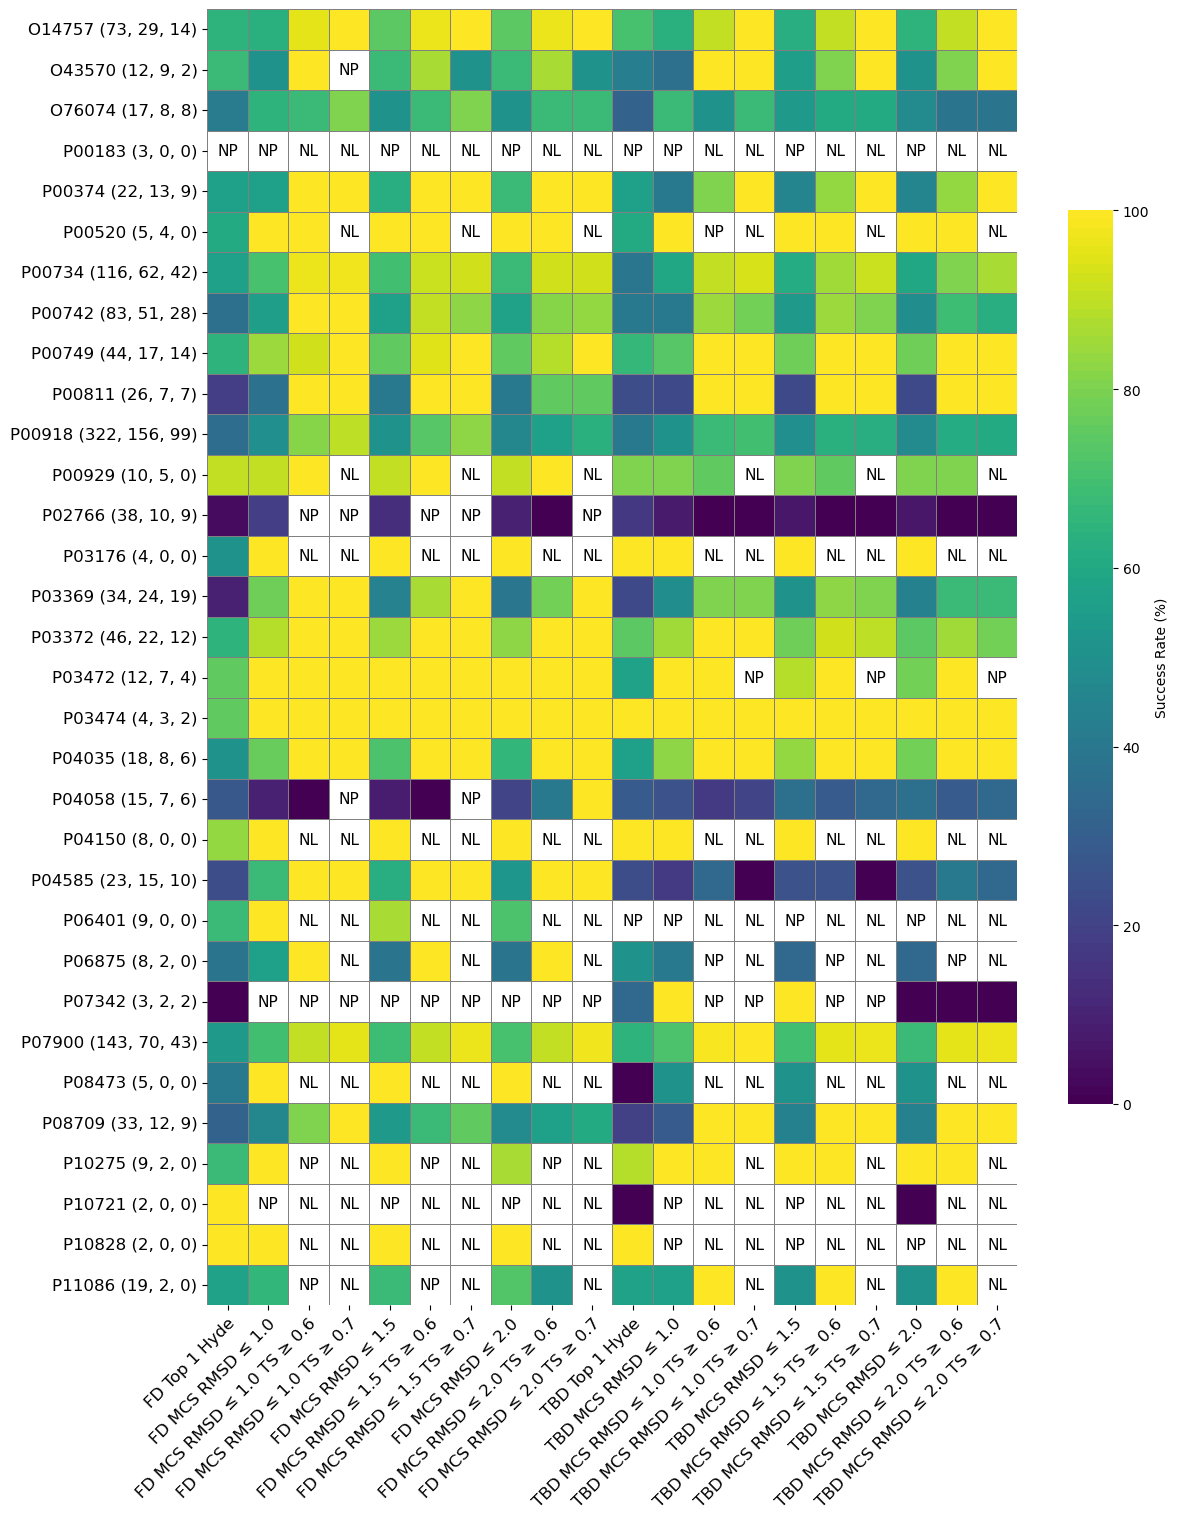

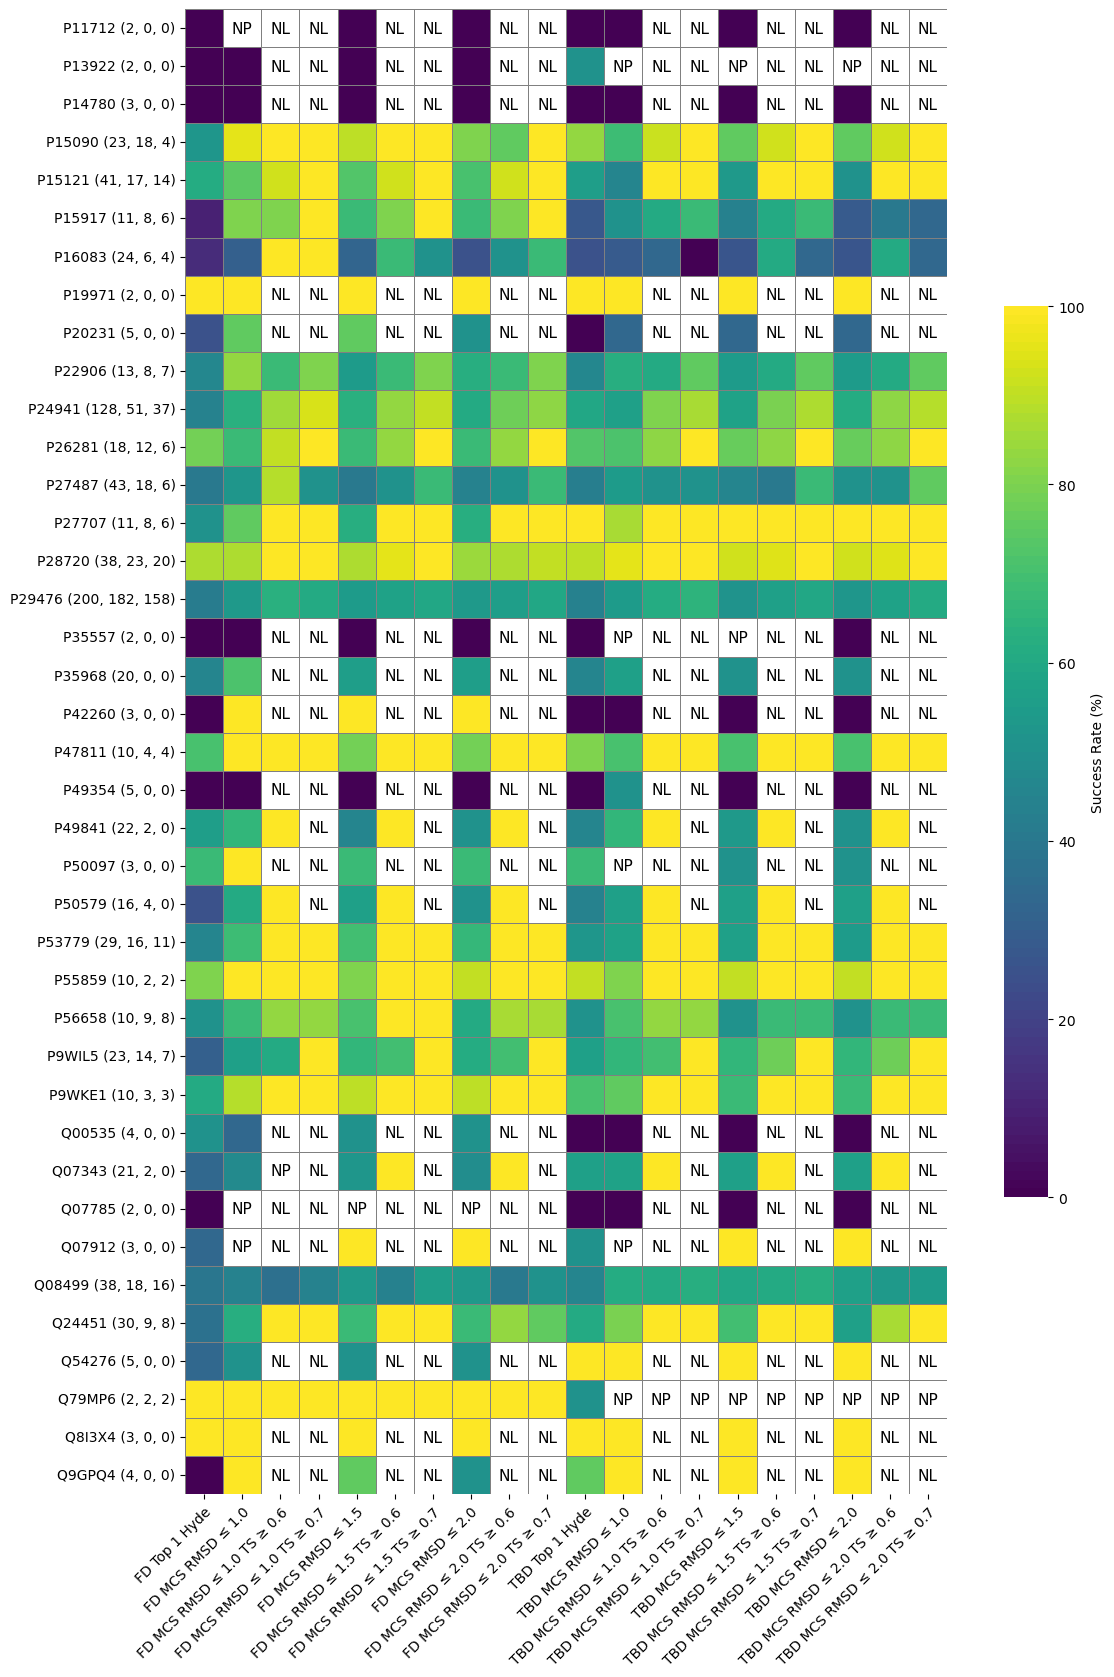

In [428]:
df_colored = pair_left.map(lambda x: np.nan if x in [-2, -1] else x)


df_colored.index = [f'{i} ({similarity_df.loc[i].Ligands}, {similarity_df.loc[i].TS_6}, {similarity_df.loc[i].TS_7})' for i in df_colored.index]

colors = list(sns.color_palette("viridis", as_cmap=True)(np.linspace(0, 1, 100)))
cmap = ListedColormap(colors)

def add_white_cells_with_annotations(ax, df_ex):
    for (i, j), val in np.ndenumerate(df_ex.values):
        if val == -1:
            ax.text(j + 0.5, i + 0.5, 'NL', color='black', ha='center', va='center', fontsize=11)
        elif val == -2:
            ax.text(j + 0.5, i + 0.5, 'NP', color='black', ha='center', va='center', fontsize=11)
#         else:
#             if target_sr.iloc[i, j] > 70:
#                 ax.text(j + 0.5, i + 0.5, int(val), color='black', ha='center', va='center', fontsize=11)
#             else:
#                 ax.text(j + 0.5, i + 0.5, int(val), color='white', ha='center', va='center', fontsize=11)

# === First heatmap ===
fig1, ax1 = plt.subplots(figsize=(12.4, 16.88))
sns.heatmap(
    df_colored.iloc[:32, :],
    ax=ax1,
    cmap=cmap,
    annot=False,
    cbar=True,
    vmin=0,
    vmax=100,
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={'label': 'Success Rate (%)', 'shrink': 0.6, "orientation": "vertical"}
)
add_white_cells_with_annotations(ax1, pair_left.iloc[:32, :])
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
plt.tight_layout()
# Save first image
plt.savefig("../images/success_rate_per_target_unique_part1.png", dpi=300, bbox_inches='tight')
plt.show()

fig2, ax2 = plt.subplots(figsize=(12.4, 16.88))
sns.heatmap(
    df_colored.iloc[32:, :],
    ax=ax2,
    cmap=cmap,
    annot=False,
    cbar=True,
    vmin=0,
    vmax=100,
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={'label': 'Success Rate (%)', 'shrink': 0.6, "orientation": "vertical"}
)
add_white_cells_with_annotations(ax2, pair_left.iloc[32:, :])
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax3.set_xticklabels(ax2.get_xticklabels(), fontsize=12)
ax3.set_yticklabels(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
# Save second image
plt.savefig("../images/success_rate_per_target_unique_part2.png", dpi=300, bbox_inches='tight')
plt.show()


In [336]:
result_rows = []

for idx, row in astex.iterrows():
    uniprot = row['UniProt_ID']
    template = row['Template']
    
    sim_col = similarity_matrix[template]
    
    # Build DataFrame for this pair
    df_temp = pd.DataFrame({
        'UniProt_ID': uniprot,
        'Template': template,
        'Ligand': sim_col.index,
        'Tanimoto_Similarity': sim_col.values
    })
    
    result_rows.append(df_temp)

# Concatenate all results into one DataFrame
final_df = pd.concat(result_rows, ignore_index=True)

final_df = final_df[final_df.Template != final_df.Ligand]


In [339]:
final_df_6 = final_df[final_df.Tanimoto_Similarity >= 0.6]
final_df_7 = final_df[final_df.Tanimoto_Similarity >= 0.7]

In [341]:
len(final_df_6.Ligand.unique())

1043

In [342]:
len(final_df_7.Ligand.unique())

735

In [ ]:
for i, uni in enumerate(uniprots):
    for col in target_sr.columns:
        if '0.6' in col:
            if count_df[count_df.UniProt_ID == uni].TS_6.iloc[0] == 0:
                pair_left.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                if target_df.empty:
                    pair_left.loc[uni, str(col)] = -2
                else:
                    lig_pairs = count_df[count_df.UniProt_ID == uni]['TS_6'].iloc[0]
                    total_pairs = lig_pairs*2
                    pair_left.loc[uni, str(col)] = round(len(target_df[target_df.hyde_rmsd <= 2])/total_pairs, 2)*100
                    
        elif '0.7' in col:
            if count_df[count_df.UniProt_ID == uni].TS_7.iloc[0] == 0:
                pair_left.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                if target_df.empty:
                    pair_left.loc[uni, str(col)] = -2
                else:
                    lig_pairs = count_df[count_df.UniProt_ID == uni]['TS_7'].iloc[0]
                    total_pairs = lig_pairs*2
                    pair_left.loc[uni, str(col)] = round(len(target_df[target_df.hyde_rmsd <= 2])/total_pairs, 2)*100
        else:
            target_df = col_df_dict[col]
            target_df = target_df[target_df.UniProt_ID == uni]
            if target_df.empty:
                pair_left.loc[uni, str(col)] = -2
            else:
                lig_pairs = count_df[count_df.UniProt_ID == uni]['count'].iloc[0]
                total_pairs = lig_pairs*(lig_pairs-1)
                pair_left.loc[uni, str(col)] = round(len(target_df[target_df.hyde_rmsd <= 2])/total_pairs, 2)*100
# pair_left = pair_left.drop('P04818')
pair_left

# Pose analysis of FD MCS RMSD < 2 and TS > 0.7

In [285]:
final_mcs_rmsd = fd_mcs_20_7_hs.copy()
ref_lig_rmsd = pd.read_csv('../data/reference_ligands_rmsd.csv')


In [286]:
len(final_mcs_rmsd)

916

In [287]:
merged = final_mcs_rmsd.merge(ref_lig_rmsd[['Template', 'Docked', 'rmsd']], on=['Template', 'Docked'], how='left')
merged_8_h = merged[merged.hyde_rmsd >=8]
merged_8_r = merged[merged.rmsd >=8]


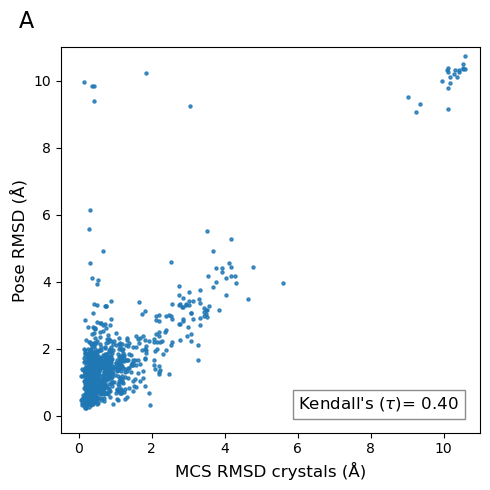

In [395]:
tau, p_value = kendalltau(merged.rmsd, merged.hyde_rmsd)

fig, ax = plt.subplots(figsize=(5, 5))

hb = ax.scatter(merged.rmsd, merged.hyde_rmsd, s=5, alpha=0.8)

ax.text(0.95, 0.05, f'Kendall\'s ($\\tau$)= {tau:.2f}',
        transform=ax.transAxes, fontsize=12, ha='right', va='bottom',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))

ax.set_xlabel('MCS RMSD crystals (Å)', fontsize=12)
ax.set_xlim(-0.5, 11)
ax.set_ylabel('Pose RMSD (Å)', fontsize=12)
ax.set_ylim(-0.5, 11)

ax.text(-0.1, 1.05, 'A', fontsize=16, transform=ax.transAxes)

plt.tight_layout()
plt.savefig('../images/scatterplot_all_mcs2_ts7.png', dpi=300, bbox_inches='tight')
plt.show()


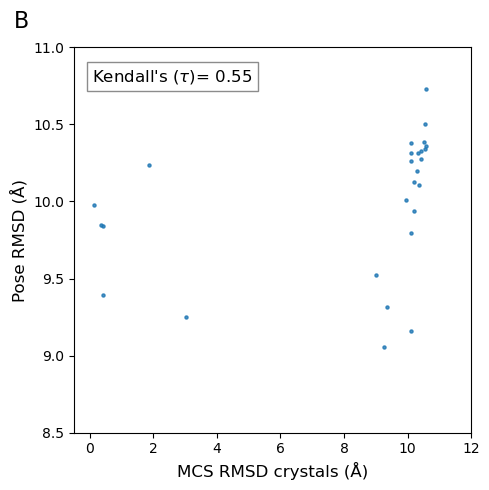

In [414]:
tau, p_value = kendalltau(merged_8_h.rmsd, merged_8_h.hyde_rmsd)

fig, ax = plt.subplots(figsize=(5, 5))

hb = ax.scatter(merged_8_h.rmsd, merged_8_h.hyde_rmsd, s=5, alpha=0.8)

ax.text(0.45, 0.9, f'Kendall\'s ($\\tau$)= {tau:.2f}',
        transform=ax.transAxes, fontsize=12, ha='right', va='bottom',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))

ax.set_xlabel('MCS RMSD crystals (Å)', fontsize=12)
ax.set_ylabel('Pose RMSD (Å)', fontsize=12)
ax.set_xlim(-0.5, 12)
ax.set_ylim(8.5, 11)
ax.text(-0.15, 1.05, 'B', fontsize=16, transform=ax.transAxes)

plt.tight_layout()
plt.savefig('../images/scatterplot_pose_mcs2_ts7.png', dpi=300, bbox_inches='tight')
plt.show()


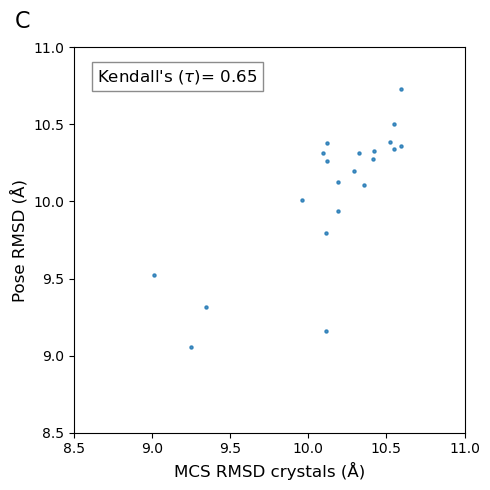

In [412]:
tau, p_value = kendalltau(merged_8_r.rmsd, merged_8_r.hyde_rmsd)

fig, ax = plt.subplots(figsize=(5, 5))
hb = ax.scatter(merged_8_r.rmsd, merged_8_r.hyde_rmsd, s=5, alpha=0.8)

ax.text(0.47, 0.9, f'Kendall\'s ($\\tau$)= {tau:.2f}',
        transform=ax.transAxes, fontsize=12, ha='right', va='bottom',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))

ax.set_xlabel('MCS RMSD crystals (Å)', fontsize=12)
ax.set_xlim(8.5, 11)
ax.set_ylabel('Pose RMSD (Å)', fontsize=12)
ax.set_ylim(8.5, 11)

ax.text(-0.15, 1.05, 'C', fontsize=16, transform=ax.transAxes)

plt.tight_layout()
plt.savefig('../images/scatterplot_cryst_mcs2_ts7.png', dpi=300, bbox_inches='tight')
plt.show()


In [280]:
corr = merged['rmsd'].corr(merged['hyde_rmsd'], method='kendall')
print(f"Kendall's tau correlation: {round(corr,2)}")

corr_h = merged_8_h['hyde_rmsd'].corr(merged_8_h['rmsd'], method='kendall')
print(f"Kendall's tau correlation: {round(corr_h,2)}")

corr_r = merged_8_r['rmsd'].corr(merged_8_r['hyde_rmsd'], method='kendall')
print(f"Kendall's tau correlation: {round(corr_r,2)}")


Kendall's tau correlation: 0.39
Kendall's tau correlation: 0.21
Kendall's tau correlation: 0.44


In [160]:
# final_target = target_sr['FD MCS RMSD ≤ 2.0 TS ≥ 0.6']
# final_hyde = target_sr['FD Top 1 Hyde']


In [168]:
print(f'Targets TS > 7: {len(final_target) - len(final_target[final_target == -1])}')
print(f'Targets 100% SR: \n \
    Hyde: {len(final_hyde[final_hyde == 100])} \
    TS > 7: {len(final_target[final_target == 100])} \n\
Targets < 20% SR: \n \
    Hyde: {len(final_hyde[final_hyde <= 20])} \
    TS > 7: {len(final_target[(final_target <= 20) & (final_target != -2) & (final_target != -1)])} \n\
Targets > 90% SR: \n \
    Hyde: {len(final_hyde[final_hyde >= 90])} \
    TS > 7: {len(final_target[(final_target >= 90) & (final_target != -2) & (final_target != -1)])} \n\
Targets 80-90% SR: \n \
    Hyde: {len(final_hyde[(final_hyde >= 80) & (final_target <= 90)])} \
    TS > 7: {len(final_target[(final_target >= 80) & (final_target <= 90) & (final_target != -2) & (final_target != -1)])} \
      \
      \
      \
      ')

Targets TS > 7: 48
Targets 100% SR: 
     Hyde: 3     TS > 7: 15 
Targets < 20% SR: 
     Hyde: 37     TS > 7: 3 
Targets > 90% SR: 
     Hyde: 4     TS > 7: 22 
Targets 80-90% SR: 
     Hyde: 5     TS > 7: 7                         


In [281]:
final_mcs_rmsd_no_wrong_crysts = merged[merged.rmsd < 8]

In [282]:
final_mcs_rmsd_no_wrong_crysts


,UniProt_ID,Template,Docked,Pose,hyde_rmsd,hyde_score,mcs_rmsd,Tanimoto_Similarity,rmsd
0,O14757,1NVQ_UCN,1NVR_STU,1,1.305,5.480429e+02,1.260,0.726027,0.207
1,O14757,1NVR_STU,1NVQ_UCN,2,1.409,3.228247e+02,1.401,0.726027,0.207
2,O14757,2BR1_PFP,2BRB_PFQ,2,1.096,1.571699e+07,1.031,0.729167,0.319
3,O14757,2BRB_PFQ,2BR1_PFP,9,1.352,1.606970e+04,1.119,0.729167,0.319
4,O14757,2BRB_PFQ,2BRH_DFW,3,1.996,2.505207e+06,1.107,0.717391,1.208
...,...,...,...,...,...,...,...,...,...
2021,Q24451,3EJS_HN5,3EJU_HN7,4,0.839,5.469743e+02,0.989,0.640000,1.166
2022,Q24451,3EJT_HN6,3EJR_HN4,6,1.021,4.238563e+02,1.413,0.640000,1.195
2023,Q24451,3EJT_HN6,3EJU_HN7,1,1.401,3.077139e+03,1.102,0.640000,0.780
2024,Q79MP6,1JJE_BYS,1JJT_BDS,7,1.381,2.527050e+01,0.502,0.882353,1.081


In [283]:
len(final_mcs_rmsd_no_wrong_crysts[final_mcs_rmsd_no_wrong_crysts.hyde_rmsd <= 2])/len(final_mcs_rmsd_no_wrong_crysts)



0.7525150905432596

In [284]:
len(final_mcs_rmsd[final_mcs_rmsd.hyde_rmsd <= 2])/len(final_mcs_rmsd)

0.7384007897334649

In [171]:
bad = merged[merged.hyde_rmsd >= 8].sort_values(by='Tanimoto_Similarity', ascending=False).reset_index(drop=True)
len(bad)

27

In [186]:
bad

,UniProt_ID,Template,Docked,Pose,hyde_rmsd,mcs_rmsd,Tanimoto_Similarity,rmsd
0,P29476,3JWU_J11,3JX3_JI5,6,10.361,1.460,1.000000,10.594
1,P29476,3JX3_JI5,3JWV_J14,1,10.272,1.705,1.000000,10.416
2,P29476,3JX3_JI5,3JWU_J11,6,10.727,0.822,1.000000,10.594
3,P29476,4LUX_QJ8,4CX6_Q16,7,10.504,1.293,1.000000,10.546
4,P29476,4CTQ_S5D,4CTP_2IK,1,10.125,0.977,1.000000,10.188
5,P29476,4CTP_2IK,4CTQ_S5D,2,9.941,1.091,1.000000,10.188
6,P29476,4CX6_Q16,4LUX_QJ8,5,10.342,1.614,1.000000,10.546
7,P29476,3NNZ_59W,3NNY_59R,1,10.107,0.654,1.000000,10.360
8,P29476,4CTT_S7K,4CTQ_S5D,6,10.007,1.682,0.826087,9.962
9,P29476,3NLK_JSS,3NNY_59R,4,10.198,0.592,0.803279,10.295


In [173]:
bad = bad.drop(columns='hyde_score')


In [182]:
len(bad.Docked.unique())

17

In [176]:
top10_hyde = fd_hyde_rmsd_top1.copy()

# top10_bad = top10_hyde[(top10_hyde.Template.isin(bad.Template)) & (top10_hyde.Docked.isin(bad.Docked))]
# top10_bad

keys = set(zip(bad['Template'], bad['Docked']))

# Use a boolean mask to filter df1
top10_bad = top10_hyde[top10_hyde[['Template', 'Docked']].apply(tuple, axis=1).isin(keys)]

len(top10_bad[top10_bad.hyde_rmsd <= 2])/len(top10_bad)

0.14814814814814814

In [181]:
len(top10_bad[top10_bad.hyde_rmsd <= 2])

4

In [180]:
top10_bad.sort_values(by='Tanimoto_Similarity', ascending=False).reset_index(drop=True)

,UniProt_ID,Template,Docked,Pose,flexx_rmsd,flexx_score,hyde_rmsd,hyde_score,mcs_rmsd,Tanimoto_Similarity
0,P29476,3JWU_J11,3JX3_JI5,2,4.413,-36.96,4.261,1.282493e+05,9.630,1.000000
1,P29476,3JX3_JI5,3JWV_J14,1,10.090,-51.61,10.272,7.380533e+03,1.705,1.000000
2,P29476,3JX3_JI5,3JWU_J11,7,2.836,-46.94,2.660,8.180960e+03,10.463,1.000000
3,P29476,4LUX_QJ8,4CX6_Q16,10,2.262,-31.62,0.871,1.103923e+04,10.474,1.000000
4,P29476,4CTQ_S5D,4CTP_2IK,6,1.317,-29.07,1.085,1.489672e+02,10.002,1.000000
5,P29476,4CTP_2IK,4CTQ_S5D,5,9.088,-37.40,9.183,7.537575e+07,2.496,1.000000
6,P29476,4CX6_Q16,4LUX_QJ8,7,9.357,-35.53,9.821,3.457423e+08,3.893,1.000000
7,P29476,3NNZ_59W,3NNY_59R,3,8.655,-33.96,8.486,9.938876e+05,6.906,1.000000
8,P29476,4CTT_S7K,4CTQ_S5D,9,9.021,-33.76,8.760,1.180156e+12,4.367,0.826087
9,P29476,3NLK_JSS,3NNY_59R,9,9.557,-35.75,9.457,6.957702e+06,2.798,0.803279
